In [1]:
# packages

from collections import defaultdict, OrderedDict, Counter
from datetime import datetime

from dateutil.relativedelta import relativedelta
import glob
from itertools import product, combinations
import matplotlib.pyplot as plt
import numpy    as np
#import networkx as nx
from operator import itemgetter
import pandas   as pd
import rdflib as rdflib
import re
from scipy.signal import convolve2d
import seaborn as sns
from sklearn.preprocessing import MultiLabelBinarizer, minmax_scale
from SPARQLWrapper import SPARQLWrapper, JSON, POST, TURTLE
import sys
from rdflib.namespace import XSD, Namespace
from rdflib.term import URIRef

import IPython
import pprint
pp = pprint.PrettyPrinter(indent=4)



from constants import *
from helpers import *

In [2]:
# helpers

# tuples
end_year=2022
start_year=1971
period_length=5
year_range = end_year - start_year
modulo = year_range % period_length
if modulo == 0:
    final_start = end_year - period_length
else:
    final_start = end_year - modulo
final_end = end_year + 1

starts = np.arange(start_year, final_start, period_length).tolist()
tuples = [(start, start+period_length) for start in starts]# five year periods
# make 5-year bins


# We'll add the last period calculated earlier
tuples.append(tuple([final_start, final_end]))
bins = pd.IntervalIndex.from_tuples(tuples, closed='left')
original_labels = list(bins.astype(str))
new_labels = ['{} - {}'.format(b.strip('[)').split(', ')[0], int(b.strip('[)').split(', ')[1])-1) for b in original_labels]
label_dict = dict(zip(original_labels, new_labels))

# add period function
def add_period(df_fo, columnname="year"):
    df_fo['period'] = pd.cut(df_fo[columnname], bins=bins, include_lowest=True, precision=0)
    df_fo['period'] = df_fo['period'].astype("str")

    df_fo["period"]=df_fo["period"].apply(lambda x: int(x.split(",")[0].replace("[","")))
    return df_fo

# decade function
def add_decade(df_fi, columname="year"):
    df_fi["decade"]=(df_fi["year"]-1)- ((df_fi["year"]-1)%10)
    
    return df_fi

In [3]:
df_fi=pd.read_csv("../../data/df_fi_all.csv", sep="\t", index_col=0)
df_fo=pd.read_csv("../../data/df_fo_all2.csv", sep="\t", index_col=0)

In [181]:
# translated graph
from rdflib import Graph
g = Graph() 
g.parse('../../data/nat_lang_graph2.nt')

# finnish graph

f = Graph() 

f.parse('../../data/finnish_graph_new.nt')

<Graph identifier=N2fb4dceb5d634ff1b7a6e98f7cd14417 (<class 'rdflib.graph.Graph'>)>

In [4]:
fi_pub=df_fi.dropna(subset="publisher")


fi_pub[["publisher","pubName"]].nunique() # as many names as 

publisher    777
pubName      777
dtype: int64

In [5]:
print(fi_pub[fi_pub["pubName"].str.contains("Karjala")]["pubName"].unique())


['Karjala' 'Karjala-kustantamo' 'Karjalan kirjapaino'
 'Karjalan sivistyseura']


In [6]:
fi_pub["lang"]="http://lexvo.org/id/iso639-3/fin"

/tmp/ipykernel_26527/2961609278.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fi_pub["lang"]="http://lexvo.org/id/iso639-3/fin"


In [7]:
fo_pub=df_fo.dropna(subset="publisher")
print(fo_pub[fo_pub["pubName"].str.contains("Karjala")]["pubName"].unique())

# replace "Karjala" with "Karjala-Kustantamo"

fo_pub[["publisher","pubName"]].nunique() # as many names as 

['Karjala']


publisher    323
pubName      323
dtype: int64

In [8]:
fo_pub.groupby("lang")["novel"].nunique().sort_values()

lang
http://lexvo.org/id/iso639-3/glg        1
http://lexvo.org/id/iso639-3/lat        1
http://lexvo.org/id/iso639-3/kik        1
http://lexvo.org/id/iso639-5/fiu        1
http://lexvo.org/id/iso639-3/hrv        1
http://lexvo.org/id/iso639-3/hin        1
http://lexvo.org/id/iso639-3/lit        1
http://lexvo.org/id/iso639-3/fit        1
http://lexvo.org/id/iso639-3/vec        1
http://lexvo.org/id/iso639-3/mkd        1
http://lexvo.org/id/iso639-3/chm        1
http://lexvo.org/id/iso639-5/bnt        1
http://lexvo.org/id/iso639-3/bel        1
http://lexvo.org/id/iso639-3/ben        1
http://lexvo.org/id/iso639-3/vie        1
http://lexvo.org/id/iso639-3/bos        1
http://lexvo.org/id/iso639-3/ind        2
http://lexvo.org/id/iso639-3/slk        2
http://lexvo.org/id/iso639-3/hye        2
http://lexvo.org/id/iso639-3/ukr        3
http://lexvo.org/id/iso639-3/kat        3
http://lexvo.org/id/iso639-3/grc        3
http://lexvo.org/id/iso639-3/srp        3
http://lexvo.org/id/iso639-3/

In [9]:
#  top x

top_fi=df_fi.groupby(["pubName","publisher"])["novel"].nunique().sort_values(ascending=False).head(10).reset_index()
top_fi

,pubName,publisher,novel
0,WSOY,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,1946
1,Otava,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,1810
2,Tammi,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,1550
3,Eget förlag,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,1039
4,Karisto Oy,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,984
5,BoD - Books on Demand,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,935
6,Gummerus,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,771
7,Myllylahti,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,461
8,Mediapinta Oy,http://www.seco.tkk.fi/applications/saha#Insta...,313
9,Kustannus-Mäkelä,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,273


In [10]:
omakustantajat=list(top_fi[top_fi["pubName"].isin(["Eget förlag","BoD - Books on Demand", "Mediapinta Oy"])]["publisher"])

In [11]:
#all_pubs[all_pubs["pubName"].str.contains("Bookcover")]

In [12]:
all_pubs=pd.concat([fi_pub, fo_pub])
all_pubs.sort_values(by="year")

,year,author,nat,gender,novel,publisher,pubName,genre,year_genre,decade,lang
60,1971,http://www.yso.fi/onto/kaunokki#person_1231760...,http://www.yso.fi/onto/koko/p73101,http://www.yso.fi/onto/kaunokki#male,http://www.yso.fi/onto/kaunokki#ateos_10280,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,Kustannusosakeyhtiö Otava,NaN,NaN,NaN,http://lexvo.org/id/iso639-3/eng
10007,1971,http://www.yso.fi/onto/kaunokki#person_1231759...,http://www.yso.fi/onto/koko/p35259,http://www.yso.fi/onto/kaunokki#female,http://www.yso.fi/onto/kaunokki#ateos_19267,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,Weilin + Göös,jannitys,1971.0,1970.0,http://lexvo.org/id/iso639-3/fin
142,1971,http://www.yso.fi/onto/kaunokki#person_1231759...,http://www.yso.fi/onto/koko/p2224,http://www.yso.fi/onto/kaunokki#female,http://www.yso.fi/onto/kaunokki#ateos_4288,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,Kustannusosakeyhtiö Tammi,jannitys,NaN,1970.0,http://lexvo.org/id/iso639-3/eng
141,1971,http://www.yso.fi/onto/kaunokki#person_1231759...,http://www.yso.fi/onto/koko/p2224,http://www.yso.fi/onto/kaunokki#male,http://www.yso.fi/onto/kaunokki#ateos_3996,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,WSOY,jannitys,NaN,1970.0,http://lexvo.org/id/iso639-3/eng
140,1971,http://www.yso.fi/onto/kaunokki#person_1231759...,http://www.yso.fi/onto/koko/p73101,http://www.yso.fi/onto/kaunokki#male,http://www.yso.fi/onto/kaunokki#ateos_8820,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,Kustannusosakeyhtiö Tammi,jannitys,NaN,1970.0,http://lexvo.org/id/iso639-3/eng
...,...,...,...,...,...,...,...,...,...,...,...
5969,2020,http://data.kirjasampo.fi/actor_Luik%2C+Rolf,http://www.yso.fi/onto/koko/p35259,http://www.yso.fi/onto/kaunokki#male,http://data.kirjasampo.fi/abstractWork_7114472,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,BoD - Books on Demand,huumori,2020.0,2010.0,http://lexvo.org/id/iso639-3/fin
5971,2020,http://data.kirjasampo.fi/actor_Kivel%C3%A4%2C...,http://www.yso.fi/onto/koko/p35259,http://www.yso.fi/onto/kaunokki#female,http://data.kirjasampo.fi/abstractWork_7128521,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,BoD - Books on Demand,NaN,NaN,NaN,http://lexvo.org/id/iso639-3/fin
6012,2020,http://seco.tkk.fi/saha3/uf6c4db79-57f6-49a5-b...,http://www.yso.fi/onto/koko/p35259,http://www.yso.fi/onto/kaunokki#female,http://data.kirjasampo.fi/abstractWork_7055985,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,WSOY,NaN,NaN,NaN,http://lexvo.org/id/iso639-3/fin
5768,2020,http://www.yso.fi/onto/kaunokki#person_1231759...,http://www.yso.fi/onto/koko/p35259,http://www.yso.fi/onto/kaunokki#male,http://data.kirjasampo.fi/abstractWork_7085099,http://data.kirjasampo.fi/actor_Aviador,Aviador,NaN,NaN,NaN,http://lexvo.org/id/iso639-3/fin


In [29]:
# filter out all < 30 novels
verysmall= all_pubs.groupby("publisher")["novel"].nunique().reset_index()#<30
smalls=verysmall[verysmall["novel"]<30]
# filter out books on demand, mediapinta, omakustanne
not_wanted= list(smalls["publisher"]) + omakustantajat
real_pubs=all_pubs[~all_pubs["publisher"].isin(not_wanted)]
real_pubs



,year,author,nat,gender,novel,publisher,pubName,genre,year_genre,decade,lang
2,1972,http://seco.tkk.fi/saha3/uc84440c2-42e7-4ba7-b...,http://www.yso.fi/onto/koko/p35259,http://www.yso.fi/onto/kaunokki#female,http://www.yso.fi/onto/kaunokki#ateos_20145,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,Weilin + Göös,NaN,NaN,NaN,http://lexvo.org/id/iso639-3/fin
4,2017,http://www.btj.fi/actor_Matilainen%2C+Pekka,http://www.yso.fi/onto/koko/p35259,http://www.yso.fi/onto/kaunokki#male,http://data.kirjasampo.fi/abstractWork_4409323,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,Atena Kustannus Oy,jannitys,2017.0,2010.0,http://lexvo.org/id/iso639-3/fin
5,1982,http://www.yso.fi/onto/kaunokki#person_1231759...,http://www.yso.fi/onto/koko/p35259,http://www.yso.fi/onto/kaunokki#male,http://www.yso.fi/onto/kaunokki#ateos_44817,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,WSOY,jannitys,1982.0,1980.0,http://lexvo.org/id/iso639-3/fin
6,2006,http://www.yso.fi/onto/kaunokki#person_1231759...,http://www.yso.fi/onto/koko/p35259,http://www.yso.fi/onto/kaunokki#female,http://seco.tkk.fi/saha3/u04ea928f-31f2-4ebd-a...,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,Tammi,NaN,NaN,NaN,http://lexvo.org/id/iso639-3/fin
7,1984,http://seco.tkk.fi/saha3/u9d2d1008-80a8-4f00-9...,http://www.yso.fi/onto/koko/p35259,unk,http://seco.tkk.fi/saha3/u6332bb33-146f-499b-a...,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,Tammi,jannitys,1984.0,1980.0,http://lexvo.org/id/iso639-3/fin
...,...,...,...,...,...,...,...,...,...,...,...
19395,2020,http://data.kirjasampo.fi/actor_Ahnhem%2C+Stefan,http://www.yso.fi/onto/koko/p16897,http://www.yso.fi/onto/kaunokki#male,http://data.kirjasampo.fi/abstractWork_7029250,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,WSOY,jannitys,NaN,2010.0,http://lexvo.org/id/iso639-3/swe
19397,2020,http://www.yso.fi/onto/kaunokki#person_1231760...,http://www.yso.fi/onto/koko/p2224,http://www.yso.fi/onto/kaunokki#female,http://data.kirjasampo.fi/abstractWork_4435226,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,Karisto Oy,jannitys,NaN,2010.0,http://lexvo.org/id/iso639-3/eng
19398,2020,http://data.kirjasampo.fi/actor_Sehlstedt%2C+K...,http://www.yso.fi/onto/koko/p16897,http://www.yso.fi/onto/kaunokki#female,http://data.kirjasampo.fi/abstractWork_6986740,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,Like,jannitys,NaN,2010.0,http://lexvo.org/id/iso639-3/swe
19399,2020,http://data.kirjasampo.fi/actor_Harris%2C+Neil...,http://www.yso.fi/onto/koko/p73101,http://www.yso.fi/onto/kaunokki#male,http://data.kirjasampo.fi/abstractWork_7094878,http://data.kirjasampo.fi/actor_Aula+%26+Co,Kustannusosakeyhtiö Aula & Co,NaN,NaN,NaN,http://lexvo.org/id/iso639-3/eng


In [36]:
# get min year, max year, nr of publications
pub_profiles=pd.DataFrame()

pub_profiles["min"]=real_pubs.groupby("publisher")["year"].min().values
pub_profiles["max"]=real_pubs.groupby("publisher")["year"].max().values
pub_profiles["novels"]=real_pubs.groupby("publisher")["novel"].nunique().values
pub_profiles["authors"]=real_pubs.groupby("publisher")["author"].nunique().values
fi_count=real_pubs[real_pubs["lang"]=="http://lexvo.org/id/iso639-3/fin"].groupby("publisher")["novel"].nunique().reset_index()
pub_profiles["publisher"]=real_pubs.groupby("publisher")["year"].min().index
pub_profiles["pubName"]=real_pubs.groupby("publisher")["pubName"].unique().values
pub_profiles=pub_profiles.merge(fi_count, how="left")
pub_profiles["novel_fi"]=pub_profiles["novel"].fillna(0)

In [37]:
pub_profiles

,min,max,novels,authors,publisher,pubName,novel,novel_fi
0,2018,2020,66,48,http://data.kirjasampo.fi/actor_Atrain+%26+Nord,"[Atrain & Nord, Atrain&Nord]",61.0,61.0
1,2016,2020,63,40,http://data.kirjasampo.fi/actor_Aula+%26+Co,"[Aula & Co, Kustannusosakeyhtiö Aula & Co]",16.0,16.0
2,2015,2020,54,43,http://data.kirjasampo.fi/actor_Aviador,"[Aviador, Aviador Kustannus]",27.0,27.0
3,2015,2020,293,152,http://data.kirjasampo.fi/actor_HarperCollins+...,[HarperCollins Nordic AB],NaN,0.0
4,2016,2020,82,51,http://data.kirjasampo.fi/actor_S%26S,"[S&S, Kustantamo S&S]",26.0,26.0
...,...,...,...,...,...,...,...,...
76,1997,2020,44,27,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,[Nemo],8.0,8.0
77,1974,2020,92,37,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,[Aikamedia],44.0,44.0
78,1986,2017,192,110,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,[Harlequin],NaN,0.0
79,1987,2020,56,32,http://www.yso.fi/onto/kaunokki#Kustantaja_146...,[Suomen Rauhanyhdistysten Keskusyhdistys ry],56.0,56.0


In [38]:
pub_profiles["age"]=pub_profiles["max"]-pub_profiles["min"]

In [39]:
pub_profiles["finnishness"]=pub_profiles["novel_fi"]/pub_profiles["novels"]

In [40]:
pub_profiles["oldness"]=2020-pub_profiles["min"]#-pub_profiles["min"]

In [41]:
pub_profiles.rename({"age":"ikä","finnishness":"suom. osuus"},axis=1)

,min,max,novels,authors,publisher,pubName,novel,novel_fi,ikä,suom. osuus,oldness
0,2018,2020,66,48,http://data.kirjasampo.fi/actor_Atrain+%26+Nord,"[Atrain & Nord, Atrain&Nord]",61.0,61.0,2,0.924242,2
1,2016,2020,63,40,http://data.kirjasampo.fi/actor_Aula+%26+Co,"[Aula & Co, Kustannusosakeyhtiö Aula & Co]",16.0,16.0,4,0.253968,4
2,2015,2020,54,43,http://data.kirjasampo.fi/actor_Aviador,"[Aviador, Aviador Kustannus]",27.0,27.0,5,0.500000,5
3,2015,2020,293,152,http://data.kirjasampo.fi/actor_HarperCollins+...,[HarperCollins Nordic AB],NaN,0.0,5,0.000000,5
4,2016,2020,82,51,http://data.kirjasampo.fi/actor_S%26S,"[S&S, Kustantamo S&S]",26.0,26.0,4,0.317073,4
...,...,...,...,...,...,...,...,...,...,...,...
76,1997,2020,44,27,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,[Nemo],8.0,8.0,23,0.181818,23
77,1974,2020,92,37,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,[Aikamedia],44.0,44.0,46,0.478261,46
78,1986,2017,192,110,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,[Harlequin],NaN,0.0,31,0.000000,34
79,1987,2020,56,32,http://www.yso.fi/onto/kaunokki#Kustantaja_146...,[Suomen Rauhanyhdistysten Keskusyhdistys ry],56.0,56.0,33,1.000000,33


In [42]:
novels_per_year=real_pubs.groupby(["year","publisher"])["novel"].nunique().reset_index()
novels_per_year=novels_per_year.groupby("publisher")["novel"].mean().reset_index()

In [45]:
pub_profiles=pub_profiles.merge(novels_per_year, on="publisher", suffixes=["","_year"])

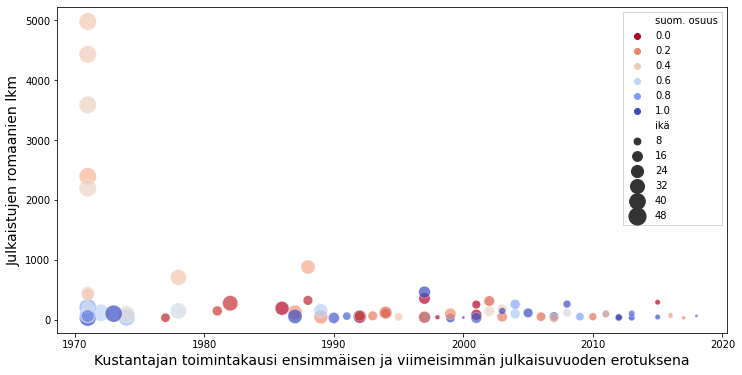

In [46]:
fig, ax= plt.subplots(1,1,figsize=(12,6))


ax=sns.scatterplot(y="novels",x= "min",ax=ax, hue="suom. osuus", data=pub_profiles.rename({"age":"ikä","finnishness":"suom. osuus"},axis=1), 
                   palette=sns.color_palette("coolwarm_r", as_cmap=True),
                  s=60, alpha=0.7, 
                   size="ikä", sizes=(10,300)
                  )#, width=0.8)
plt.legend(loc='best', 
           #bbox_to_anchor=(1.12, 0.5), 
         #  title="suom. osuus",
          ncol=1, fancybox=False, shadow=False)
#plt.margins(0,0)
#plt.yticks([0, 10, 100, 1000, 4000])
plt.xlabel("Kustantajan toimintakausi ensimmäisen ja viimeisimmän julkaisuvuoden erotuksena", fontsize=14)
plt.ylabel("Julkaistujen romaanien lkm", fontsize=14)
ax.xaxis.set_tick_params(rotation=0)

coordinates = [('WSOY',46.1,4950), ('Otava',46,4410), ('Tammi',45.7,3560), ("Gummerus",44.1,2380), ("Karisto",45.6,2150),
               ("Kustannus-Mäkelä",34.2,710), ("Like", 30, 890)]
for x in coordinates: plt.annotate(x[0], (x[1], x[2] ))

In [47]:
from matplotlib import collections as matcoll

In [52]:
pub_profiles["novel_year"].sort_values()

50      1.600000
45      1.727273
42      1.777778
30      1.920000
79      1.931034
         ...    
19     48.180000
3      48.833333
20     72.220000
61     89.000000
60    100.260000
Name: novel_year, Length: 81, dtype: float64

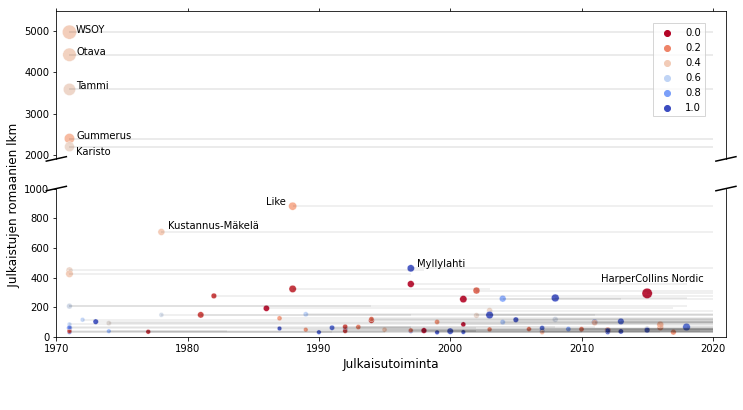

In [75]:
import matplotlib.pyplot as plt
import numpy as np


# 30 points between [0, 0.2) originally made using np.random.rand(30)*.2
pts = np.array([
    0.015, 0.166, 0.133, 0.159, 0.041, 0.024, 0.195, 0.039, 0.161, 0.018,
    0.143, 0.056, 0.125, 0.096, 0.094, 0.051, 0.043, 0.021, 0.138, 0.075,
    0.109, 0.195, 0.050, 0.074, 0.079, 0.155, 0.020, 0.010, 0.061, 0.008])

# Now let's make two outlier points which are far away from everything.
pts[[3, 14]] += .8

# If we were to simply plot pts, we'd lose most of the interesting
# details due to the outliers. So let's 'break' or 'cut-out' the y-axis
# into two portions - use the top (ax) for the outliers, and the bottom
# (ax2) for the details of the majority of our data
fig, (ax, ax2) = plt.subplots(2, 1, sharex=True,figsize=(12,6))

# plot the same data on both axes
#ax.plot(pts)
#ax2.plot(pts)

lines=[]
lines2=[]
for start,end,novels in zip(pub_profiles["min"],pub_profiles["max"],pub_profiles["novels"]):
    #ax2.plot([start,novels],[end,novels],'b-', linewidth=2,color="red")
    if novels > 900:
        lines.append([[start,novels],[end,novels]])
    else:
        lines2.append([[start,novels],[end,novels]])

    
linecoll = matcoll.LineCollection(lines, colors='k',alpha=0.1)
linecoll2 = matcoll.LineCollection(lines2, colors='k',alpha=0.08)


ax.add_collection(linecoll)
ax2.add_collection(linecoll2)


sns.scatterplot(y="novels",x= "min",ax=ax, hue="suom. osuus", data=pub_profiles.rename({"age":"ikä","finnishness":"suom. osuus"},axis=1), 
                   palette=sns.color_palette("coolwarm_r", as_cmap=True),
                  s=60, alpha=0.9, 
                size="novel_year",sizes=(20,200)
                  # size="ikä", sizes=(10,300)
                  )

sns.scatterplot(y="novels",x= "min",ax=ax2, hue="suom. osuus", data=pub_profiles.rename({"age":"ikä","finnishness":"suom. osuus"},axis=1), 
                   palette=sns.color_palette("coolwarm_r", as_cmap=True),
                  s=60, alpha=0.9, 
                   #size="ikä", sizes=(10,300)
                 size="novel_year",sizes=(20,200)
                  )

plt.legend([], frameon=False)

# zoom-in / limit the view to different portions of the data
ax.set_ylim(1900, 5500)  # outliers only
ax2.set_ylim(0, 1000)  # most of the data


ax.set_xlim(1970,2021)  # outliers only
ax2.set_xlim(1970,2021)  # most of the data

# hide the spines between ax and ax2
ax.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax.xaxis.tick_top()
ax.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()




#plt.margins(0,0)
# This looks pretty good, and was fairly painless, but you can get that
# cut-out diagonal lines look with just a bit more work. The important
# thing to know here is that in axes coordinates, which are always
# between 0-1, spine endpoints are at these locations (0,0), (0,1),
# (1,0), and (1,1).  Thus, we just need to put the diagonals in the
# appropriate corners of each of our axes, and so long as we use the
# right transform and disable clipping.

d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

# What's cool about this is that now if we vary the distance between
# ax and ax2 via f.subplots_adjust(hspace=...) or plt.subplot_tool(),
# the diagonal lines will move accordingly, and stay right at the tips
# of the spines they are 'breaking'
plt.legend([], frameon=False)


#plt.show()
handles,labels=ax.get_legend_handles_labels()

plt.legend(
    handles=handles[1:7],labels=labels[1:7],
    loc='center', 
           bbox_to_anchor=(0.93, 1.8), 
         #  title="suom. osuus",
          ncol=1, fancybox=False, shadow=False)

ax.legend("", frameon=False)
ax.set_ylabel("")
plt.xlabel("Julkaisutoiminta", fontsize=12)
plt.ylabel("                              Julkaistujen romaanien lkm", fontsize=12)

coordinates = [('WSOY',1971.5,4950), ('Otava',1971.5,4420), ('Tammi',1971.5,3590), ("Gummerus",1971.5,2380), ("Karisto",1971.5,2000),
            #   ("Kustannus-Mäkelä",34.2,710), ("Like", 30, 890)
              ]
for x in coordinates: ax.annotate(x[0], (x[1], x[2] ))

    
coordinates2 = [#('WSOY',1971.5,4950), ('Otava',1971.5,4420), ('Tammi',1971.5,3590), ("Gummerus",1971.5,2380), ("Karisto",1971.5,2000),
               ("Kustannus-Mäkelä",1978.5,730), ("Like", 1986, 890), ("Myllylahti", 1997.5,470), ("HarperCollins Nordic", 2011.5, 370)
              ]
for x in coordinates2: ax2.annotate(x[0], (x[1], x[2] ))
    
    
#fig.tight_layout()
plt.savefig("../../output/publisher_age_new.png")

In [76]:
### plotly

In [74]:
import plotly.express as px

fig = px.scatter(pub_profiles, "min", "novels", color="finnishness", 
                 #palette=sns.color_palette("coolwarm_r", as_cmap=True),
                 hover_data=['pubName', "novel_year"])
fig.show()

# descriptive stats

In [79]:
df_fi=pd.read_csv("../../data/df_fi_all.csv", sep="\t", index_col=0)
df_fo=pd.read_csv("../../data/df_fo_all2.csv", sep="\t", index_col=0)

In [85]:
fi_pub=df_fi.dropna(subset="publisher")

# replace "Karjala" with "Karjala-Kustantamo"

fi_pub[["publisher","pubName"]].nunique() # as many names as 

publisher    777
pubName      777
dtype: int64

In [86]:
fi_pub["lang"]="http://lexvo.org/id/iso639-3/fin"

/tmp/ipykernel_26527/2961609278.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [87]:
# karjala?
## are these different publishers?
print(fi_pub[fi_pub["pubName"].str.contains("Karjala")]["pubName"].unique())


['Karjala' 'Karjala-kustantamo' 'Karjalan kirjapaino'
 'Karjalan sivistyseura']


In [88]:
fo_pub=df_fo.dropna(subset="publisher")

fo_pub[["publisher","pubName"]].nunique() # as many names as 

publisher    323
pubName      323
dtype: int64

In [89]:
#  top x

top_fi=df_fi.groupby(["pubName"])["novel"].nunique().sort_values(ascending=False).head(10).reset_index()
top_fi

,pubName,novel
0,WSOY,1946
1,Otava,1810
2,Tammi,1550
3,Eget förlag,1039
4,Karisto Oy,984
5,BoD - Books on Demand,935
6,Gummerus,771
7,Myllylahti,461
8,Mediapinta Oy,313
9,Kustannus-Mäkelä,273


In [90]:
top_fo=df_fo.groupby(["pubName"])["novel"].nunique().sort_values(ascending=False).head(10).reset_index()
top_fo

,pubName,novel
0,WSOY,3032
1,Kustannusosakeyhtiö Otava,2619
2,Kustannusosakeyhtiö Tammi,2037
3,Gummerus Kustannus Oy,1623
4,Karisto Oy,1212
5,Like,628
6,Kustannus-Mäkelä,434
7,Stabenfeldt AB,355
8,Book Studio,313
9,HarperCollins Nordic AB,293


In [91]:
# concat fo and fi


publishers_df=pd.concat([df_fo[["publisher","pubName","novel","year","author"]],df_fi[["publisher","pubName","novel","year","author"]]], axis=0)

publishers_df

,publisher,pubName,novel,year,author
0,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,WSOY,http://www.yso.fi/onto/kaunokki#ateos_8518,1971,http://www.yso.fi/onto/kaunokki#person_1231759...
1,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,Gummerus Kustannus Oy,http://www.yso.fi/onto/kaunokki#ateos_23787,1971,http://www.yso.fi/onto/kaunokki#person_1231759...
2,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,Kustannusosakeyhtiö Tammi,http://www.btj.fi/at_1479755,1971,http://seco.tkk.fi/saha3/u0e364bf4-73f6-446a-9...
3,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,Kustannusosakeyhtiö Otava,http://seco.tkk.fi/saha3/u7d29e490-f7c3-48ca-b...,1971,http://seco.tkk.fi/saha3/u93bae653-78a3-4a7a-a...
4,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,Weilin + Göös,http://www.yso.fi/onto/kaunokki#ateos_6328,1971,http://www.yso.fi/onto/kaunokki#person_1231760...
...,...,...,...,...,...
17023,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,Otava,http://data.kirjasampo.fi/abstractWork_6969400,2019,http://data.kirjasampo.fi/actor_Nikki%2C+Teemu
17024,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,Otava,http://data.kirjasampo.fi/abstractWork_6969400,2019,http://data.kirjasampo.fi/actor_P%C3%B6s%C3%B6...
17025,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,Myllylahti,http://data.kirjasampo.fi/abstractWork_7037934,2020,http://data.kirjasampo.fi/actor_Silvan%2C+Heidi
17026,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,Otava,http://www.yso.fi/onto/kaunokki#ateos_38615,1990,http://www.yso.fi/onto/kaunokki#person_1231759...


In [92]:
pubsizes=publishers_df.groupby(["publisher"])["novel","author"].nunique()

/tmp/ipykernel_26527/3911709559.py:1: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



In [93]:
#publishers_df.dropna(["pubName"])[publishers_df["pubName"].str.contains("Gummerus")]
publishers_df.pubName.nunique(),publishers_df.publisher.nunique()#.sort_values()

publishers_df[(publishers_df["pubName"].str.contains("BoD"))|(publishers_df["pubName"].str.contains("Mediapinta"))].publisher.unique()
publishers_df[(publishers_df["pubName"].str.contains("Eget"))|(publishers_df["pubName"].str.contains("Omakustanne"))].publisher.unique()

array(['http://www.yso.fi/onto/kaunokki#Kustantaja_123176050600519'],
      dtype=object)

In [95]:
# categorize per size
big=pubsizes[(pubsizes["novel"]>1000) &(pubsizes["author"]>20) ].reset_index()
# set criteria to be a real publisher
small=pubsizes[(pubsizes["novel"]>30) &(pubsizes["novel"]<401) &(pubsizes["author"]>20) ].reset_index()
med=pubsizes[(pubsizes["novel"]>400) &(pubsizes["novel"]<1001) &(pubsizes["author"]>20) ].reset_index()
own=med[(med["publisher"].isin(['http://www.yso.fi/onto/kaunokki#Kustantaja_123175911046523',
       'http://www.seco.tkk.fi/applications/saha#Instance_ID1245218989086']))]
own=pd.concat([own,big[big["publisher"]=='http://www.yso.fi/onto/kaunokki#Kustantaja_123176050600519']])
med=med[~med["publisher"].isin(own["publisher"])]
medpubs=list(med["publisher"].unique())
print(len(med))
med.merge(publishers_df[["publisher","pubName"]].drop_duplicates("publisher")).sort_values(by="novel")

5


,publisher,novel,author,pubName
4,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,425,191,Weilin + Göös
1,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,448,218,Kirjayhtymä
0,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,462,173,Myllylahti Oy
2,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,707,193,Kustannus-Mäkelä
3,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,881,381,Like


In [96]:
big.merge(publishers_df[["publisher","pubName"]].drop_duplicates("publisher")).sort_values(by="novel")

,publisher,novel,author,pubName
2,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,1048,716,Eget förlag
5,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,2196,621,Karisto Oy
0,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,2394,758,Gummerus Kustannus Oy
1,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,3587,973,Kustannusosakeyhtiö Tammi
4,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,4429,1403,Kustannusosakeyhtiö Otava
3,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,4978,1655,WSOY


In [97]:
small.merge(publishers_df[["publisher","pubName"]].drop_duplicates("publisher")).sort_values(by="novel")

,publisher,novel,author,pubName
5,http://data.kirjasampo.fi/actor_Tiberius+kirjat,31,24,Tiberius kirjat
13,http://www.btj.fi/actor_Kustannusosakeyhti%C3%...,32,29,Kustannusosakeyhtiö Hai
38,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,32,23,Herättäjä-yhdistys
27,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,34,22,Love kirjat
26,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,35,26,Kirjaneliö
6,http://data.kirjasampo.fi/actor_V%C3%A4yl%C3%A4,36,24,Väyläkirjat
29,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,38,29,MC-Pilot
33,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,38,28,Karas-Sana Oy
48,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,39,25,Sanasato
36,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,39,24,Kirjalito


In [98]:
big=big[big["publisher"]!='http://www.yso.fi/onto/kaunokki#Kustantaja_123176050600519']
big.publisher.unique()

array(['http://www.yso.fi/onto/kaunokki#Kustantaja_123175899315611',
       'http://www.yso.fi/onto/kaunokki#Kustantaja_123175899745141',
       'http://www.yso.fi/onto/kaunokki#Kustantaja_123272659490249',
       'http://www.yso.fi/onto/kaunokki#Kustantaja_123272660482316',
       'http://www.yso.fi/onto/kaunokki#Kustantaja_123272667729627'],
      dtype=object)

In [99]:
## 

df=fi_pub
conditions = [
    (df['publisher'].isin(list(big.publisher.unique()))),
    (df['publisher'].isin(list(med.publisher.unique()))),
    (df['publisher'].isin(list(own.publisher.unique()))),
(df['publisher'].isin(list(small.publisher.unique())))]
choices = ['iso', 'keski', 'oma',"pieni"]
df['cat'] = np.select(conditions, choices, default='muu')

/tmp/ipykernel_26527/3211254285.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [100]:
fi_pub=df
fi_pub=add_period(fi_pub)

/tmp/ipykernel_26527/2774366863.py:29: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_26527/2774366863.py:30: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_26527/2774366863.py:32: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [104]:
df=fo_pub
conditions = [
    (df['publisher'].isin(list(big.publisher.unique()))),
    (df['publisher'].isin(list(med.publisher.unique()))),
    (df['publisher'].isin(list(own.publisher.unique()))),
(df['publisher'].isin(list(small.publisher.unique())))]
choices = ['iso', 'keski', 'oma',"pieni"]
df['cat'] = np.select(conditions, choices, default='muu')

/tmp/ipykernel_26527/914260202.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [105]:
fo_pub=df
fo_pub=add_period(fo_pub)

/tmp/ipykernel_26527/2774366863.py:29: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_26527/2774366863.py:30: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_26527/2774366863.py:32: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [106]:
# color palette

color_codes={"oma": sns.color_palette("PuOr")[0], "muu":sns.color_palette("PuOr")[1], "iso":sns.color_palette("PuOr")[5], "keski":sns.color_palette("PuOr")[4],"pieni":sns.color_palette("PuOr")[3]}

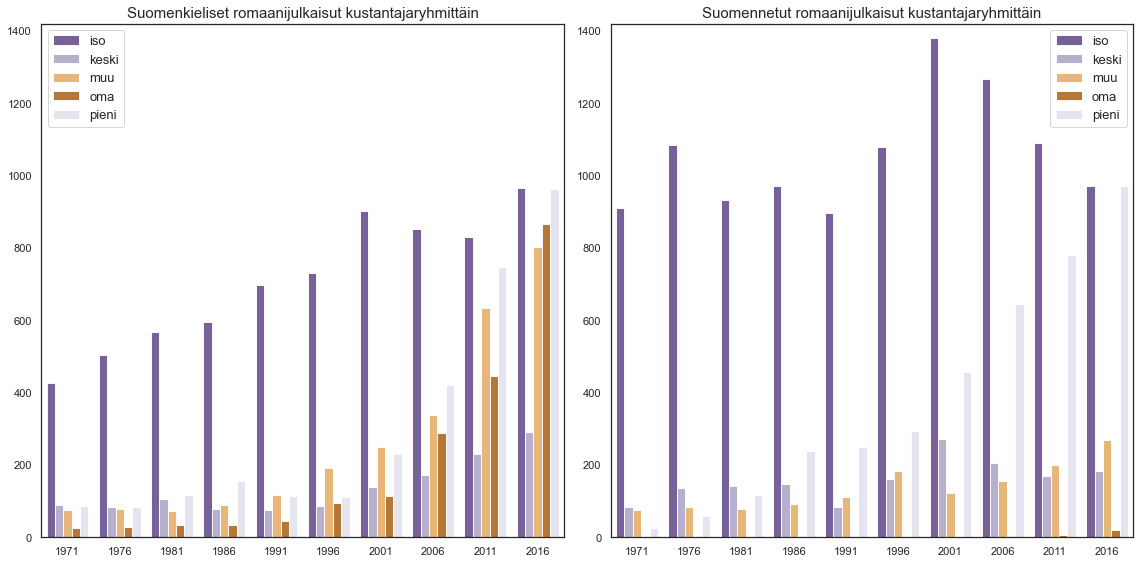

In [113]:
# plot groups

# plot 
sns.set_theme(style="white",palette="Set1")
fig, ax = plt.subplots(1,2, figsize=(16,8))

plotdf=fi_pub.groupby(["period","cat"])["novel"].nunique().reset_index().sort_values(by=["cat","period"])
#plotdf["period"]=pd.to_numeric(plotdf["period"])
bar1=sns.barplot(y="novel", x="period",hue="cat", palette=color_codes, #hue="cat",
                 data=plotdf, ax=ax[0], alpha=0.9)

plotdf2=fo_pub.groupby(["period","cat"])["novel"].nunique().reset_index().sort_values(by=["cat","period"])
#plotdf2["period"]=pd.to_numeric(plotdf2["period"])
bar2=sns.barplot(y="novel", x="period", hue="cat", data=plotdf2, ax=ax[1], palette=color_codes,alpha=0.9)
bar2.set_title("Suomennetut romaanijulkaisut kustantajaryhmittäin", fontsize=15)
bar1.set_title("Suomenkieliset romaanijulkaisut kustantajaryhmittäin", fontsize=15)
bar1.set_ylim((0,1420))
bar2.set_ylim((0,1420))
bar1.legend(title="", loc="upper left",fontsize=13)
bar2.legend(title="",fontsize=13)
bar1.set_ylabel("")
bar1.set_xlabel("")
bar2.set_xlabel("")
bar2.set_ylabel("")
fig.tight_layout()
fig.savefig("../../output/pub_development_new.png")

In [114]:
all_pubs=pd.concat([fi_pub,fo_pub]).drop_duplicates(["year","author","novel","nat","lang"])
all_pubs

,year,author,nat,gender,novel,publisher,pubName,genre,year_genre,decade,lang,cat,period
0,2017,http://data.kirjasampo.fi/actor_Sovij%C3%A4rvi...,http://www.yso.fi/onto/koko/p35259,http://www.yso.fi/onto/kaunokki#male,http://data.kirjasampo.fi/abstractWork_4492055,http://data.kirjasampo.fi/actor_Arsmat,Arsmat,huumori,2017.0,2010.0,http://lexvo.org/id/iso639-3/fin,muu,2016
1,2013,http://www.btj.fi/actor_Piiroinen%2C+Aulis,http://www.yso.fi/onto/koko/p35259,http://www.yso.fi/onto/kaunokki#male,http://data.kirjasampo.fi/abstractWork_4014830,http://www.seco.tkk.fi/applications/saha#Insta...,Mediapinta Oy,NaN,NaN,NaN,http://lexvo.org/id/iso639-3/fin,pieni,2011
2,1972,http://seco.tkk.fi/saha3/uc84440c2-42e7-4ba7-b...,http://www.yso.fi/onto/koko/p35259,http://www.yso.fi/onto/kaunokki#female,http://www.yso.fi/onto/kaunokki#ateos_20145,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,Weilin + Göös,NaN,NaN,NaN,http://lexvo.org/id/iso639-3/fin,keski,1971
3,2010,http://data.kirjasampo.fi/actor_Vinnurva%2C+Pe...,http://www.yso.fi/onto/koko/p35259,http://www.yso.fi/onto/kaunokki#male,http://data.kirjasampo.fi/abstractWork_9789529...,http://data.kirjasampo.fi/actor_IPE+Tuoteapu,IPE Tuoteapu,NaN,NaN,NaN,http://lexvo.org/id/iso639-3/fin,muu,2006
4,2017,http://www.btj.fi/actor_Matilainen%2C+Pekka,http://www.yso.fi/onto/koko/p35259,http://www.yso.fi/onto/kaunokki#male,http://data.kirjasampo.fi/abstractWork_4409323,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,Atena Kustannus Oy,jannitys,2017.0,2010.0,http://lexvo.org/id/iso639-3/fin,pieni,2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19396,2020,http://www.yso.fi/onto/kaunokki#person_1231759...,http://www.yso.fi/onto/koko/p35259,http://www.yso.fi/onto/kaunokki#male,http://data.kirjasampo.fi/abstractWork_7047819,http://data.kirjasampo.fi/actor_Lector+Kustannus,Lector Kustannus Oy,jannitys,NaN,2010.0,http://lexvo.org/id/iso639-3/est,muu,2016
19397,2020,http://www.yso.fi/onto/kaunokki#person_1231760...,http://www.yso.fi/onto/koko/p2224,http://www.yso.fi/onto/kaunokki#female,http://data.kirjasampo.fi/abstractWork_4435226,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,Karisto Oy,jannitys,NaN,2010.0,http://lexvo.org/id/iso639-3/eng,iso,2016
19398,2020,http://data.kirjasampo.fi/actor_Sehlstedt%2C+K...,http://www.yso.fi/onto/koko/p16897,http://www.yso.fi/onto/kaunokki#female,http://data.kirjasampo.fi/abstractWork_6986740,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,Like,jannitys,NaN,2010.0,http://lexvo.org/id/iso639-3/swe,keski,2016
19399,2020,http://data.kirjasampo.fi/actor_Harris%2C+Neil...,http://www.yso.fi/onto/koko/p73101,http://www.yso.fi/onto/kaunokki#male,http://data.kirjasampo.fi/abstractWork_7094878,http://data.kirjasampo.fi/actor_Aula+%26+Co,Kustannusosakeyhtiö Aula & Co,NaN,NaN,NaN,http://lexvo.org/id/iso639-3/eng,pieni,2016


In [117]:
# count total publications per year
novel_year=all_pubs.groupby("year")["novel"].nunique()
cat_year=all_pubs.groupby(["year","cat"])["novel"].nunique()

new_col=all_pubs.set_index(["year"]).index.map(novel_year)
print(len(new_col), len(all_pubs))

new_col2=all_pubs.set_index(["year","cat"]).index.map(cat_year)
print(len(new_col2), len(all_pubs))

35196 35196
35196 35196


In [118]:
all_pubs["year_total"]=new_col
all_pubs["year_cat_total"]=new_col2
all_pubs["rel"] =new_col2/new_col
all_pubs.sort_values("year").head()

,year,author,nat,gender,novel,publisher,pubName,genre,year_genre,decade,lang,cat,period,year_total,year_cat_total,rel
77,1971,http://www.yso.fi/onto/kaunokki#person_1231760...,http://www.yso.fi/onto/koko/p54872,http://www.yso.fi/onto/kaunokki#male,http://www.yso.fi/onto/kaunokki#ateos_3674,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,Kustannusosakeyhtiö Otava,NaN,NaN,1970,http://lexvo.org/id/iso639-3/eng,iso,1971,320,230,0.71875
34,1971,http://www.yso.fi/onto/kaunokki#person_1231760...,http://www.yso.fi/onto/koko/p73101,http://www.yso.fi/onto/kaunokki#male,http://seco.tkk.fi/saha3/uc1598527-6933-45aa-9...,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,Kustannusosakeyhtiö Otava,NaN,NaN,1970,http://lexvo.org/id/iso639-3/eng,iso,1971,320,230,0.71875
1925,1971,http://www.yso.fi/onto/kaunokki#person_1231759...,http://www.yso.fi/onto/koko/p35259,http://www.yso.fi/onto/kaunokki#female,http://seco.tkk.fi/saha3/u5610ae31-57b3-43c9-a...,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,Karisto Oy,NaN,NaN,1970,http://lexvo.org/id/iso639-3/fin,iso,1971,320,230,0.71875
33,1971,http://seco.tkk.fi/saha3/u8716e5b8-61ea-4eb4-9...,http://www.yso.fi/onto/koko/p14632,http://www.yso.fi/onto/kaunokki#male,http://seco.tkk.fi/saha3/uf12c4f07-e729-4000-9...,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,Kustannusosakeyhtiö Tammi,NaN,NaN,1970,http://lexvo.org/id/iso639-3/nld,iso,1971,320,230,0.71875
32,1971,http://seco.tkk.fi/saha3/u36f4fcd9-03c4-4493-9...,http://www.yso.fi/onto/koko/p2224,http://www.yso.fi/onto/kaunokki#male,http://seco.tkk.fi/saha3/ub45c7ab3-7426-4414-9...,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,Kustannusosakeyhtiö Tammi,NaN,NaN,1970,http://lexvo.org/id/iso639-3/eng,iso,1971,320,230,0.71875


In [119]:
# stats

# statistical tests

# has the share of small publishers grown?
all_pubs=add_decade(all_pubs)
df90=all_pubs[all_pubs["decade"]==1990]

df21=all_pubs[all_pubs["decade"]==2010]

In [120]:
import statsmodels.api as sm
from scipy import stats
import pandas
from scipy.stats import ttest_1samp,ttest_ind
# summary t-test
# t-test
testdf=all_pubs[all_pubs["cat"]=="iso"].drop_duplicates(["year","cat"])
mean90 = testdf[testdf['decade'] == 1990]['rel']
mean2010 = testdf[testdf['decade'] == 2010]['rel']
print(np.mean(mean90), np.mean(mean2010))
print(ttest_ind(mean90, mean2010)  )


import researchpy as rp
rp.ttest(group1= mean90, group1_name= "90",
         group2= mean2010, group2_name= "10")

0.6417671435947738 0.34333816590115
Ttest_indResult(statistic=14.989467518346117, pvalue=1.3042631487794827e-11)


/u/98/peurat1/unix/kirjasampo/benv/lib/python3.8/site-packages/researchpy/ttest.py:18: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



(   Variable     N      Mean        SD        SE  95% Conf.  Interval
 0        90  10.0  0.641767  0.028739  0.009088   0.621208  0.662326
 1        10  10.0  0.343338  0.056016  0.017714   0.303267  0.383410
 2  combined  20.0  0.492553  0.159105  0.035577   0.418089  0.567016,
           Independent t-test  results
 0    Difference (90 - 10) =    0.2984
 1      Degrees of freedom =   18.0000
 2                       t =   14.9895
 3   Two side test p value =    0.0000
 4  Difference < 0 p value =    1.0000
 5  Difference > 0 p value =    0.0000
 6               Cohen's d =    6.7035
 7               Hedge's g =    6.4202
 8           Glass's delta =   10.3839
 9             Pearson's r =    0.9622)

LeveneResult(statistic=1.6540757447695242, pvalue=0.21470336216068928)


/tmp/ipykernel_26527/3372732764.py:9: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



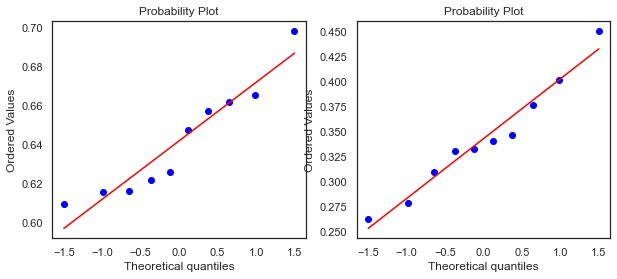

In [122]:
# assumption checking

print(stats.levene(mean90, mean2010) ) # should not be significant and is not...

fig, ax= plt.subplots(1,2,figsize=(10,4))

stats.probplot(mean90, dist="norm", plot= ax[0]) # this looks bad...
stats.probplot(mean2010, dist="norm", plot= ax[1]) 
fig.show()

In [123]:
# it is normally distributed!
sampling_difference = mean90.values - \
                      mean2010.values

stats.shapiro(sampling_difference) # does not deviate from normal distribution (goodgood)

ShapiroResult(statistic=0.9437443017959595, pvalue=0.5953781604766846)

In [124]:
## so I can report stats

In [125]:
## proportion of genre publications
genre_props=[]
for a_cat in all_pubs["cat"].unique():
    a_df=all_pubs[all_pubs["cat"]==a_cat].sort_values("year") 
    a_genredf=a_df[~a_df["genre"].isna()] # any genre
    genre_novels=a_genredf.groupby("period")["novel"].nunique()
    all_novels=a_df.groupby("period")["novel"].nunique()
    genre_prop=genre_novels/all_novels
    genre_props.append((a_cat, genre_prop))
#genre_props

color_codes={"oma": sns.color_palette("PuOr")[4], "muu":sns.color_palette("Oranges")[3], "iso":sns.color_palette("Reds")[3], "pieni":sns.color_palette("ocean")[2], "keski":sns.color_palette("Blues")[2]}

In [126]:
# nordic proportion

nordic_props=[]
nordic_langs=['http://lexvo.org/id/iso639-3/dan','http://lexvo.org/id/iso639-3/swe','http://lexvo.org/id/iso639-3/nor','http://lexvo.org/id/iso639-3/isl']
for a_cat in all_pubs["cat"].unique():
    a_df=all_pubs[all_pubs["cat"]==a_cat].sort_values("year")
    a_genredf=a_df[~a_df["lang"].isna()]
    a_genredf=a_genredf[a_genredf["lang"].isin(nordic_langs)]
    genre_novels=a_genredf.groupby("period")["novel"].nunique()
    all_novels=a_df.groupby("period")["novel"].nunique()
    genre_prop=genre_novels/all_novels
    nordic_props.append((a_cat, genre_prop))

In [127]:
# english

eng_props=[]
for a_cat in all_pubs["cat"].unique():
    a_df=all_pubs[all_pubs["cat"]==a_cat].sort_values("year")
    a_genredf=a_df[~a_df["lang"].isna()]
    a_genredf=a_genredf[a_genredf["lang"].str.contains("/eng")]
    genre_novels=a_genredf.groupby("period")["novel"].nunique()
    all_novels=a_df.groupby("period")["novel"].nunique()
    genre_prop=genre_novels/all_novels
    eng_props.append((a_cat, genre_prop))
    
len(eng_props), len(genre_props)

(5, 5)

In [128]:
df_fo2=add_period(df_fo)
df_fo2

,year,author,nat,gender,novel,lang,publisher,pubName,genre,decade,period
0,1971,http://www.yso.fi/onto/kaunokki#person_1231759...,http://www.yso.fi/onto/koko/p2224,http://www.yso.fi/onto/kaunokki#female,http://www.yso.fi/onto/kaunokki#ateos_8518,http://lexvo.org/id/iso639-3/eng,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,WSOY,NaN,NaN,1971
1,1971,http://www.yso.fi/onto/kaunokki#person_1231759...,http://www.yso.fi/onto/koko/p73101,http://www.yso.fi/onto/kaunokki#male,http://www.yso.fi/onto/kaunokki#ateos_23787,http://lexvo.org/id/iso639-3/eng,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,Gummerus Kustannus Oy,jannitys,1970.0,1971
2,1971,http://seco.tkk.fi/saha3/u0e364bf4-73f6-446a-9...,http://www.yso.fi/onto/koko/p16897,http://www.yso.fi/onto/kaunokki#male,http://www.btj.fi/at_1479755,http://lexvo.org/id/iso639-3/swe,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,Kustannusosakeyhtiö Tammi,jannitys,1970.0,1971
3,1971,http://seco.tkk.fi/saha3/u93bae653-78a3-4a7a-a...,http://www.yso.fi/onto/koko/p16897,http://www.yso.fi/onto/kaunokki#female,http://seco.tkk.fi/saha3/u7d29e490-f7c3-48ca-b...,http://lexvo.org/id/iso639-3/swe,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,Kustannusosakeyhtiö Otava,NaN,NaN,1971
4,1971,http://www.yso.fi/onto/kaunokki#person_1231760...,http://www.yso.fi/onto/koko/p12201,http://www.yso.fi/onto/kaunokki#male,http://www.yso.fi/onto/kaunokki#ateos_6328,http://lexvo.org/id/iso639-3/ita,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,Weilin + Göös,NaN,NaN,1971
...,...,...,...,...,...,...,...,...,...,...,...
19396,2020,http://www.yso.fi/onto/kaunokki#person_1231759...,http://www.yso.fi/onto/koko/p35259,http://www.yso.fi/onto/kaunokki#male,http://data.kirjasampo.fi/abstractWork_7047819,http://lexvo.org/id/iso639-3/est,http://data.kirjasampo.fi/actor_Lector+Kustannus,Lector Kustannus Oy,jannitys,2010.0,2016
19397,2020,http://www.yso.fi/onto/kaunokki#person_1231760...,http://www.yso.fi/onto/koko/p2224,http://www.yso.fi/onto/kaunokki#female,http://data.kirjasampo.fi/abstractWork_4435226,http://lexvo.org/id/iso639-3/eng,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,Karisto Oy,jannitys,2010.0,2016
19398,2020,http://data.kirjasampo.fi/actor_Sehlstedt%2C+K...,http://www.yso.fi/onto/koko/p16897,http://www.yso.fi/onto/kaunokki#female,http://data.kirjasampo.fi/abstractWork_6986740,http://lexvo.org/id/iso639-3/swe,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,Like,jannitys,2010.0,2016
19399,2020,http://data.kirjasampo.fi/actor_Harris%2C+Neil...,http://www.yso.fi/onto/koko/p73101,http://www.yso.fi/onto/kaunokki#male,http://data.kirjasampo.fi/abstractWork_7094878,http://lexvo.org/id/iso639-3/eng,http://data.kirjasampo.fi/actor_Aula+%26+Co,Kustannusosakeyhtiö Aula & Co,NaN,NaN,2016


In [140]:
fo_pub.groupby(["period","cat"])["nat"].nunique()

period  cat  
1971    iso      39
        keski    17
        muu      11
        pieni     9
1976    iso      49
        keski    19
        muu      16
        oma       1
        pieni    11
1981    iso      50
        keski    23
        muu      20
        pieni    15
1986    iso      49
        keski    24
        muu      31
        pieni    24
1991    iso      45
        keski    24
        muu      21
        oma       1
        pieni    18
1996    iso      59
        keski    17
        muu      23
        oma       3
        pieni    17
2001    iso      51
        keski    28
        muu      28
        pieni    29
2006    iso      55
        keski    28
        muu      30
        oma       2
        pieni    38
2011    iso      46
        keski    23
        muu      31
        oma       3
        pieni    49
2016    iso      44
        keski    21
        muu      37
        oma       8
        pieni    45
Name: nat, dtype: int64

In [141]:
fo_nat=fo_pub[(fo_pub["nat"]=="http://www.yso.fi/onto/koko/p35259")&(fo_pub["lang"]!="http://lexvo.org/id/iso639-3/swe")]

fo_nat.drop_duplicates(["novel"])#
fo_nat.groupby(["cat"])["novel","lang"].nunique()

/tmp/ipykernel_26527/670886806.py:4: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



,novel,lang
cat,,
iso,18,3
keski,5,3
muu,28,11
oma,5,5
pieni,10,5


In [144]:
# compare categories
piendf=all_pubs[all_pubs["cat"]=="pieni"]
smalls21=piendf[piendf["year"]> 2010]#.groupby()

#pienet=all_pubs["cat"]==small
piendf=all_pubs[all_pubs["cat"]=="pieni"]
smalls21=piendf[piendf["year"]> 2010]#.groupby()
check=smalls21.groupby("publisher")["novel"].nunique() > 2 
check=check.reset_index()
check=check[check["novel"]==True]
smalls21=smalls21[smalls21["publisher"].isin(list(check["publisher"]))]
eng_small=smalls21[smalls21["lang"].str.contains("eng")].groupby("publisher")["novel"].nunique() / smalls21.groupby("publisher")["novel"].nunique()#.reset_index()
nordic_small=smalls21[smalls21["lang"].isin(nordic_langs)].groupby("publisher")["novel"].nunique() / smalls21.groupby("publisher")["novel"].nunique()#.reset_index()
gender_small=smalls21[smalls21["gender"].str.contains("female")].groupby("publisher")["novel"].nunique() / smalls21.groupby("publisher")["novel"].nunique()#.reset_index()
fin_small=smalls21[smalls21["lang"].str.contains("fin")].groupby("publisher")["novel"].nunique() / smalls21.groupby("publisher")["novel"].nunique()#.reset_index()
genre_small=smalls21[~smalls21["genre"].isna()].groupby("publisher")["novel"].nunique() / smalls21.groupby("publisher")["novel"].nunique()

indices=pd.concat([fin_small,eng_small,nordic_small, gender_small,genre_small], axis=1).fillna(0)

pub_indices=indices.set_axis([ 'fin','eng', 'nordic', 'gender',"genre"], axis=1, inplace=False).reset_index()
pub_indices["vuosikymmen"]=2010

<AxesSubplot:xlabel='variable', ylabel='value'>

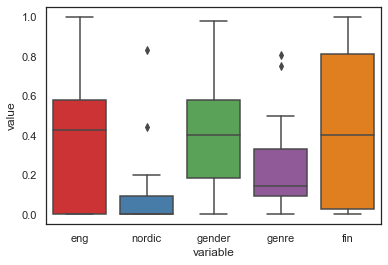

In [145]:
#pienet=all_pubs["cat"]==small
piendf=all_pubs[all_pubs["cat"]=="pieni"]
smalls21=piendf[(piendf["year"]< 2001) &(piendf["year"]> 1990)]#.groupby()
check=smalls21.groupby("publisher")["novel"].nunique() > 2 
check=check.reset_index()
check=check[check["novel"]==True]
smalls21=smalls21[smalls21["publisher"].isin(list(check["publisher"]))]
eng_small=smalls21[smalls21["lang"].str.contains("eng")].groupby("publisher")["novel"].nunique() / smalls21.groupby("publisher")["novel"].nunique()#.reset_index()
nordic_small=smalls21[smalls21["lang"].isin(nordic_langs)].groupby("publisher")["novel"].nunique() / smalls21.groupby("publisher")["novel"].nunique()#.reset_index()
gender_small=smalls21[smalls21["gender"].str.contains("female")].groupby("publisher")["novel"].nunique() / smalls21.groupby("publisher")["novel"].nunique()#.reset_index()
fin_small=smalls21[smalls21["lang"].str.contains("fin")].groupby("publisher")["novel"].nunique() / smalls21.groupby("publisher")["novel"].nunique()#.reset_index()
genre_small=smalls21[~smalls21["genre"].isna()].groupby("publisher")["novel"].nunique() / smalls21.groupby("publisher")["novel"].nunique()

indices=pd.concat([fin_small,eng_small,nordic_small, gender_small,genre_small], axis=1).fillna(0)

indices=pd.concat([fin_small,eng_small,nordic_small, gender_small,genre_small], axis=1).fillna(0)

pub_indices90=indices.set_axis([ 'fin','eng', 'nordic', 'gender',"genre"], axis=1, inplace=False).reset_index()
pub_indices90["vuosikymmen"]=1990
sns.boxplot(x="variable", y="value", data=pd.melt(pub_indices90[['eng', 'nordic', 'gender',"genre", 'fin']]))#, cut=0, alpha=0.5)


In [146]:
allix=pd.concat([pub_indices90,pub_indices])
smallcomp=pd.melt(allix[['fin','eng', 'nordic', 'gender',"genre", "vuosikymmen"]], id_vars=["vuosikymmen"])

<AxesSubplot:xlabel='variable', ylabel='value'>

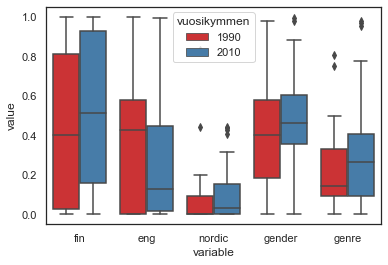

In [147]:
sns.boxplot(x="variable", y="value", data=smallcomp, hue="vuosikymmen")#, cut=0, alpha=0.5)


In [148]:
# same for the big publishers

#pienet=all_pubs["cat"]==small
piendf=all_pubs[all_pubs["cat"].isin(["iso","keski"])]
smalls21=piendf[piendf["year"]> 2010]#.groupby()

eng_small=smalls21[smalls21["lang"].str.contains("eng")].groupby("publisher")["novel"].nunique() / smalls21.groupby("publisher")["novel"].nunique()#.reset_index()
nordic_small=smalls21[smalls21["lang"].isin(nordic_langs)].groupby("publisher")["novel"].nunique() / smalls21.groupby("publisher")["novel"].nunique()#.reset_index()
gender_small=smalls21[smalls21["gender"].str.contains("female")].groupby("publisher")["novel"].nunique() / smalls21.groupby("publisher")["novel"].nunique()#.reset_index()
fin_small=smalls21[smalls21["lang"].str.contains("fin")].groupby("publisher")["novel"].nunique() / smalls21.groupby("publisher")["novel"].nunique()#.reset_index()
genre_small=smalls21[~smalls21["genre"].isna()].groupby("publisher")["novel"].nunique() / smalls21.groupby("publisher")["novel"].nunique()

indices=pd.concat([fin_small,eng_small,nordic_small, gender_small,genre_small], axis=1).fillna(0)

pub_indices20=indices.set_axis([ 'fin','eng', 'nordic', 'gender',"genre"], axis=1, inplace=False).reset_index()
pub_indices20["vuosikymmen"]=2010

In [149]:
all_pubs.drop_duplicates(["novel","lang"])["novel"].nunique(),all_pubs["novel"].nunique() # there's a mistake!!

print(len(fo_pub.drop_duplicates(["novel","lang"])),len(fo_pub.drop_duplicates(["novel"])),fo_pub["novel"].nunique(),len(fo_pub["novel"]) )# there's a mistake!!

17189 17189 17189 19254


<AxesSubplot:xlabel='variable', ylabel='value'>

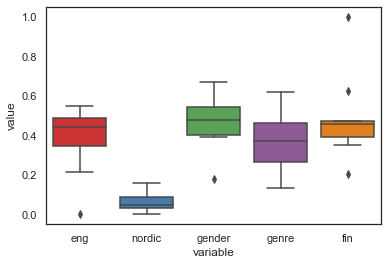

In [150]:
#pienet=all_pubs["cat"]==small
piendf=all_pubs[all_pubs["cat"].isin(["iso","keski"])]
smalls21=piendf[(piendf["year"]< 2001) &(piendf["year"]> 1990)]#.groupby()
smalls21=smalls21[smalls21["publisher"]!="http://www.yso.fi/onto/kaunokki#Kustantaja_123272662788180"]
eng_small=smalls21[smalls21["lang"].isin(english)].groupby("publisher")["novel"].nunique() / smalls21.groupby("publisher")["novel"].nunique()#.reset_index()
nordic_small=smalls21[smalls21["lang"].isin(nordic_langs)].groupby("publisher")["novel"].nunique() / smalls21.groupby("publisher")["novel"].nunique()#.reset_index()
gender_small=smalls21[smalls21["gender"].str.contains("female")].groupby("publisher")["novel"].nunique() / smalls21.groupby("publisher")["novel"].nunique()#.reset_index()
fin_small=smalls21[smalls21["lang"].str.contains("fin")].groupby("publisher")["novel"].nunique() / smalls21.groupby("publisher")["novel"].nunique()#.reset_index()
genre_small=smalls21[~smalls21["genre"].isna()].groupby("publisher")["novel"].nunique() / smalls21.groupby("publisher")["novel"].nunique()

indices=pd.concat([fin_small,eng_small,nordic_small, gender_small,genre_small], axis=1).fillna(0)

indices=pd.concat([fin_small,eng_small,nordic_small, gender_small,genre_small], axis=1).fillna(0)

pub_indices=indices.set_axis([ 'fin','eng', 'nordic', 'gender',"genre"], axis=1, inplace=False).reset_index()
pub_indices["vuosikymmen"]=1990
sns.boxplot(x="variable", y="value", data=pd.melt(pub_indices[['eng', 'nordic', 'gender',"genre", 'fin']]))#, cut=0, alpha=0.5)


In [151]:
allixbig=pd.concat([pub_indices,pub_indices20])
bigcomp=pd.melt(allixbig[['fin','eng', 'nordic', 'gender',"genre", "vuosikymmen"]], id_vars=["vuosikymmen"])

<AxesSubplot:xlabel='variable', ylabel='value'>

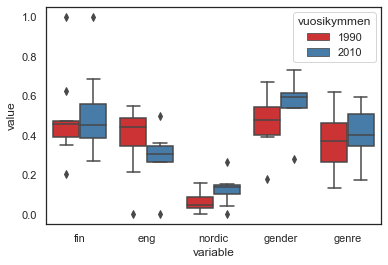

In [152]:
sns.boxplot(x="variable", y="value", data=bigcomp, hue="vuosikymmen")#, cut=0, alpha=0.5)


In [153]:
# concat
bigcomp["ryhmä"]="isot"
smallcomp["ryhmä"]="pienet"
allcomp=pd.concat([bigcomp,smallcomp])

In [154]:
group=str(allcomp["vuosikymmen"])+" "+allcomp["ryhmä"]
allcomp["group"]=allcomp["vuosikymmen"].astype(str)+", " +allcomp["ryhmä"]
allcomp #df["Period"] = df['Courses'].astype(str) +"-"+ df["Duration"]


,vuosikymmen,variable,value,ryhmä,group
0,1990,fin,0.353261,isot,"1990, isot"
1,1990,fin,0.468661,isot,"1990, isot"
2,1990,fin,1.000000,isot,"1990, isot"
3,1990,fin,0.622951,isot,"1990, isot"
4,1990,fin,0.455172,isot,"1990, isot"
...,...,...,...,...,...
340,2010,genre,0.310345,pienet,"2010, pienet"
341,2010,genre,0.083333,pienet,"2010, pienet"
342,2010,genre,0.333333,pienet,"2010, pienet"
343,2010,genre,0.976331,pienet,"2010, pienet"


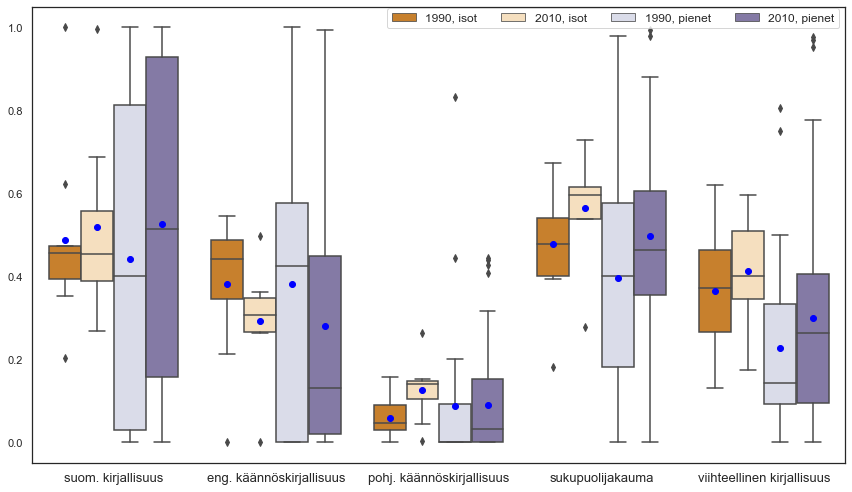

In [172]:
fig, axs = plt.subplots(1,1, figsize=(12,7))

axs1=sns.boxplot(x="variable", y="value", data=allcomp, hue="group", palette=sns.color_palette("PuOr",4), ax=axs, showmeans=True, meanprops={"marker":"o","markerfacecolor":"blue", "markeredgecolor":"blue"})
#axs2=sns.boxplot(x="variable", y="value", data=smallcomp, hue="vuosikymmen", palette=sns.color_palette("PuOr"), ax=axs[1])
#axs[1].legend([], frameon=False)
fig.tight_layout()
axs1.legend(loc="upper right", fontsize=12, ncol=4,bbox_to_anchor=(1., 1.01) )
axs1.set_ylabel("")
axs1.set_xlabel("")
axs1.set_xticklabels(["suom. kirjallisuus","eng. käännöskirjallisuus","pohj. käännöskirjallisuus","sukupuolijakauma","viihteellinen kirjallisuus"],fontsize=13)
fig.tight_layout()
fig.savefig("../../output/big_small_comp_new.png", bbox_inches='tight')

# big publishers plot



In [175]:
publisher_list=["http://www.yso.fi/onto/kaunokki#Kustantaja_123272659490249", "http://www.yso.fi/onto/kaunokki#Kustantaja_123272660482316"
               ,"http://www.yso.fi/onto/kaunokki#Kustantaja_123175899745141", "http://www.yso.fi/onto/kaunokki#Kustantaja_123175899315611" ,"http://www.yso.fi/onto/kaunokki#Kustantaja_123272667729627"]

pub_string = " ".join(["<"+p+">" for p in publisher_list])
pub_string

'<http://www.yso.fi/onto/kaunokki#Kustantaja_123272659490249> <http://www.yso.fi/onto/kaunokki#Kustantaja_123272660482316> <http://www.yso.fi/onto/kaunokki#Kustantaja_123175899745141> <http://www.yso.fi/onto/kaunokki#Kustantaja_123175899315611> <http://www.yso.fi/onto/kaunokki#Kustantaja_123272667729627>'

In [182]:
Q_pub="""
SELECT DISTINCT ?publisher ?teos ?author ?vuosi_ ?kieliuri

WHERE {

  ?teos a kaunokki:romaani . 
  ?teos kaunokki:alkukieli ?kieliuri ; kaunokki:tekija ?author ; kaunokki:manifests_in ?julkaisu .
  FILTER (?kieliuri !=  <http://lexvo.org/id/iso639-3/fin>  )
  ?julkaisu kaunokki:hasPublisher ?publisher .
  FILTER (?publisher = MYVALUE)
  OPTIONAL {?kieliuri skos:prefLabel ?kieli . }
  ?teos kaunokki:manifests_in ?julkaisu .
  ?julkaisu kaunokki:kieli <http://lexvo.org/id/iso639-3/fin> . # käännetty suomeksi
  FILTER EXISTS {?julkaisu kaunokki:kieli <http://lexvo.org/id/iso639-3/fin>  }
  ?julkaisu kaunokki:ilmestymisvuosi ?vuosi . ?vuosi skos:prefLabel ?vuosiluku .
  BIND(xsd:integer(?vuosiluku) AS ?vuosi_)
  FILTER(xsd:integer(?vuosiluku) > 1970)
  FILTER(xsd:integer(?vuosiluku) < 2021)

} #GROUP BY ?publisher ?pname
"""


sparql = SPARQLWrapper("http://ldf.fi/booksampo-2022/sparql")
pdf=pd.DataFrame()


for p in publisher_list:
    print(p)
    q=Q_pub.replace("MYVALUE","<"+p+">")
    sparql.setQuery(PREFIXES + q)

    sparql.addCustomHttpHeader(*list(AUTHORIZATION_HEADER.items())[0])

    sparql.setReturnFormat(JSON)
    results = sparql.query().convert()
    temp = JSON2Pandas2(results)
    pdf=pd.concat([pdf,temp])

http://www.yso.fi/onto/kaunokki#Kustantaja_123272659490249
http://www.yso.fi/onto/kaunokki#Kustantaja_123272660482316
http://www.yso.fi/onto/kaunokki#Kustantaja_123175899745141
http://www.yso.fi/onto/kaunokki#Kustantaja_123175899315611
http://www.yso.fi/onto/kaunokki#Kustantaja_123272667729627


In [183]:
Q_pub="""
SELECT DISTINCT ?publisher ?teos ?author ?vuosi_ ?kieliuri

WHERE {

  ?teos a kaunokki:romaani . 
  ?teos kaunokki:alkukieli ?kieliuri ; kaunokki:tekija ?author ; kaunokki:manifests_in ?julkaisu .
  FILTER (?kieliuri =  <http://lexvo.org/id/iso639-3/fin>  ) # suomenkielinen
  ?julkaisu kaunokki:hasPublisher ?publisher .
  FILTER (?publisher = MYVALUE)
  OPTIONAL {?kieliuri skos:prefLabel ?kieli . }
  ?teos kaunokki:manifests_in ?julkaisu .
  ?julkaisu kaunokki:kieli <http://lexvo.org/id/iso639-3/fin> . # julkaisu suomeksi
  FILTER EXISTS {?julkaisu kaunokki:kieli <http://lexvo.org/id/iso639-3/fin>  }
  ?julkaisu kaunokki:ilmestymisvuosi ?vuosi . ?vuosi skos:prefLabel ?vuosiluku .
  BIND(xsd:integer(?vuosiluku) AS ?vuosi_)
  FILTER(xsd:integer(?vuosiluku) > 1970)
  FILTER(xsd:integer(?vuosiluku) < 2021)

} #GROUP BY ?publisher ?pname
"""


sparql = SPARQLWrapper("http://ldf.fi/booksampo-2022/sparql")
pdf_fi=pd.DataFrame()


for p in publisher_list:
    print(p)
    q=Q_pub.replace("MYVALUE","<"+p+">")
    sparql.setQuery(PREFIXES + q)

    sparql.addCustomHttpHeader(*list(AUTHORIZATION_HEADER.items())[0])

    sparql.setReturnFormat(JSON)
    results = sparql.query().convert()
    temp = JSON2Pandas2(results)
    pdf_fi=pd.concat([pdf_fi,temp])

http://www.yso.fi/onto/kaunokki#Kustantaja_123272659490249
http://www.yso.fi/onto/kaunokki#Kustantaja_123272660482316
http://www.yso.fi/onto/kaunokki#Kustantaja_123175899745141
http://www.yso.fi/onto/kaunokki#Kustantaja_123175899315611
http://www.yso.fi/onto/kaunokki#Kustantaja_123272667729627


In [184]:
myQ ="""

PREFIX foaf: <http://xmlns.com/foaf/0.1/> 
PREFIX kaunokki: <http://www.yso.fi/onto/kaunokki#> 
PREFIX rel: <http://ldf.fi/relse/> 
PREFIX skos: <http://www.w3.org/2004/02/skos/core#> 
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#> 

SELECT DISTINCT ?teos ?author  ?gender  ?nation ?lang # (COUNT(DISTINCT ?nationality) as ?nationalityCount) #?gender #(COUNT(DISTINCT ?authorF) as ?f_authors) (COUNT(DISTINCT ?authorM) as ?m_authors)  
WHERE {
  
 
  ?teos rel:hasAuthor ?author .
  ?teos rel:langOrig ?lang .
  OPTIONAL {  ?author rel:authorNationality ?nationality. }
  BIND(COALESCE(?nationality, "unk") AS ?nation)
  OPTIONAL { ?author foaf:gender ?foafgender . }
  BIND(COALESCE(?foafgender, "unk") AS ?gender)
  
} 

"""

au_res =g.query(myQ)

reslist = [{k :v.toPython() for k,v in r.asdict().items()} for r in au_res]

author_df= pd.DataFrame(reslist)
author_df.head()

,teos,author,gender,nation,lang
0,http://www.yso.fi/onto/kaunokki#ateos_41068,http://www.yso.fi/onto/kaunokki#person_1231760...,http://www.yso.fi/onto/kaunokki#male,http://www.yso.fi/onto/koko/p6292,http://lexvo.org/id/iso639-3/dan
1,http://seco.tkk.fi/saha3/u69dbedbd-3392-4efe-9...,http://seco.tkk.fi/saha3/u242e6b79-0691-446a-9...,http://www.yso.fi/onto/kaunokki#male,http://www.yso.fi/onto/koko/p3113,http://lexvo.org/id/iso639-3/nor
2,http://www.yso.fi/onto/kaunokki#ateos_1347,http://www.yso.fi/onto/kaunokki#person_1231760...,http://www.yso.fi/onto/kaunokki#male,http://www.yso.fi/onto/koko/p2224,http://lexvo.org/id/iso639-3/eng
3,http://www.yso.fi/onto/kaunokki#ateos_36968,http://www.yso.fi/onto/kaunokki#person_1231760...,http://www.yso.fi/onto/kaunokki#male,http://www.yso.fi/onto/koko/p73101,http://lexvo.org/id/iso639-3/eng
4,http://data.kirjasampo.fi/abstractWork_9789524...,http://www.yso.fi/onto/kaunokki#person_1231760...,http://www.yso.fi/onto/kaunokki#male,http://www.yso.fi/onto/koko/p73101,http://lexvo.org/id/iso639-3/eng


In [185]:
# work language (clean)
myQ ="""

PREFIX foaf: <http://xmlns.com/foaf/0.1/> 
PREFIX kaunokki: <http://www.yso.fi/onto/kaunokki#> 
PREFIX rel: <http://ldf.fi/relse/> 
PREFIX skos: <http://www.w3.org/2004/02/skos/core#> 
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#> 

SELECT DISTINCT ?teos ?lang # (COUNT(DISTINCT ?nationality) as ?nationalityCount) #?gender #(COUNT(DISTINCT ?authorF) as ?f_authors) (COUNT(DISTINCT ?authorM) as ?m_authors)  
WHERE {
  
 
  ?teos rel:hasAuthor ?author .
  ?teos rel:langOrig ?lang .
  
  
} 

"""

l_res =g.query(myQ)

reslist = [{k :v.toPython() for k,v in r.asdict().items()} for r in l_res]

In [186]:
lang_df= pd.DataFrame(reslist)
lang_df.head()


,teos,lang
0,http://www.yso.fi/onto/kaunokki#ateos_41068,http://lexvo.org/id/iso639-3/dan
1,http://seco.tkk.fi/saha3/u69dbedbd-3392-4efe-9...,http://lexvo.org/id/iso639-3/nor
2,http://www.yso.fi/onto/kaunokki#ateos_1347,http://lexvo.org/id/iso639-3/eng
3,http://www.yso.fi/onto/kaunokki#ateos_36968,http://lexvo.org/id/iso639-3/eng
4,http://data.kirjasampo.fi/abstractWork_9789524...,http://lexvo.org/id/iso639-3/eng


In [187]:
# for Finnish

myQ ="""

PREFIX foaf: <http://xmlns.com/foaf/0.1/> 
PREFIX kaunokki: <http://www.yso.fi/onto/kaunokki#> 
PREFIX rel: <http://ldf.fi/relse/> 
PREFIX skos: <http://www.w3.org/2004/02/skos/core#> 
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#> 

SELECT DISTINCT ?author  ?gender  ?nation # (COUNT(DISTINCT ?nationality) as ?nationalityCount) #?gender #(COUNT(DISTINCT ?authorF) as ?f_authors) (COUNT(DISTINCT ?authorM) as ?m_authors)  
WHERE {
  
 
  ?teos rel:hasAuthor ?author .
  OPTIONAL {  ?author rel:authorNationality ?nationality. }
  BIND(COALESCE(?nationality, "unk") AS ?nation)
  OPTIONAL { ?author foaf:gender ?foafgender . }
  BIND(COALESCE(?foafgender, "unk") AS ?gender)
  
} 

"""

au_res =f.query(myQ)

reslistfi = [{k :v.toPython() for k,v in r.asdict().items()} for r in au_res]

In [188]:
author_dffi= pd.DataFrame(reslistfi)
author_dffi.head()

,author,gender,nation
0,http://seco.tkk.fi/saha3/u6ae933da-ebb0-4100-9...,http://www.yso.fi/onto/kaunokki#female,http://www.yso.fi/onto/koko/p35259
1,http://www.btj.fi/actor_Laurikkala%2C+Ella,http://www.yso.fi/onto/kaunokki#female,http://www.yso.fi/onto/koko/p35259
2,http://www.yso.fi/onto/kaunokki#person_1231759...,http://www.yso.fi/onto/kaunokki#male,http://www.yso.fi/onto/koko/p35259
3,http://data.kirjasampo.fi/actor_Kuuna%2C+Tapio,http://www.yso.fi/onto/kaunokki#male,http://www.yso.fi/onto/koko/p35259
4,http://www.yso.fi/onto/kaunokki#person_1231760...,http://www.yso.fi/onto/kaunokki#female,http://www.yso.fi/onto/koko/p35259


In [189]:
print(len(author_df), len(pdf))
print(len(author_df.drop_duplicates("author")),len(pdf.drop_duplicates("author")))

26555 10976
8655 3420


In [196]:

a_pdf=pdf.merge(author_df, on=["author","teos"])

a_pdf2=pdf.merge(author_df, on=["author","teos"])
print(len(a_pdf2), len(a_pdf2.drop_duplicates("author")), len(a_pdf2.drop_duplicates("teos")))
a_pdf2.head()

fi_pdf=pdf_fi.merge(author_dffi, on="author")
print(len(fi_pdf), len(fi_pdf.drop_duplicates()))
fi_pdf

11330 3420 10502
7371 7371


,publisher,teos,author,vuosi_,kieliuri,gender,nation
0,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,http://www.yso.fi/onto/kaunokki#ateos_50564,http://www.yso.fi/onto/kaunokki#person_1231759...,2003,http://lexvo.org/id/iso639-3/fin,http://www.yso.fi/onto/kaunokki#male,http://www.yso.fi/onto/koko/p35259
1,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,http://www.btj.fi/at_1392744,http://www.yso.fi/onto/kaunokki#person_1231759...,2009,http://lexvo.org/id/iso639-3/fin,http://www.yso.fi/onto/kaunokki#male,http://www.yso.fi/onto/koko/p35259
2,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,http://www.yso.fi/onto/kaunokki#ateos_20462,http://www.yso.fi/onto/kaunokki#person_1231759...,2001,http://lexvo.org/id/iso639-3/fin,http://www.yso.fi/onto/kaunokki#male,http://www.yso.fi/onto/koko/p35259
3,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,http://www.yso.fi/onto/kaunokki#ateos_28665,http://www.yso.fi/onto/kaunokki#person_1231759...,1999,http://lexvo.org/id/iso639-3/fin,http://www.yso.fi/onto/kaunokki#male,http://www.yso.fi/onto/koko/p35259
4,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,http://www.yso.fi/onto/kaunokki#ateos_19706,http://www.yso.fi/onto/kaunokki#person_1231759...,2000,http://lexvo.org/id/iso639-3/fin,http://www.yso.fi/onto/kaunokki#male,http://www.yso.fi/onto/koko/p35259
...,...,...,...,...,...,...,...
7366,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,http://data.kirjasampo.fi/abstractWork_7045139,http://data.kirjasampo.fi/actor_Tuppurainen%2C...,2020,http://lexvo.org/id/iso639-3/fin,http://www.yso.fi/onto/kaunokki#female,http://www.yso.fi/onto/koko/p35259
7367,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,http://data.kirjasampo.fi/abstractWork_7083462,http://data.kirjasampo.fi/actor_Varento%2C+Vilu,2020,http://lexvo.org/id/iso639-3/fin,unk,http://www.yso.fi/onto/koko/p35259
7368,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,http://data.kirjasampo.fi/abstractWork_7083505,http://www.btj.fi/actor_Joelsson%2C+Lotta-Liisa,2020,http://lexvo.org/id/iso639-3/fin,http://www.yso.fi/onto/kaunokki#female,http://www.yso.fi/onto/koko/p35259
7369,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,http://data.kirjasampo.fi/abstractWork_7083452,http://data.kirjasampo.fi/actor_Levola%2C+Minna,2020,http://lexvo.org/id/iso639-3/fin,http://www.yso.fi/onto/kaunokki#female,http://www.yso.fi/onto/koko/p35259


In [197]:
def add_period(a_df, vuosi="year"):
    a_df['period'] = pd.cut(a_df[vuosi], bins=bins, include_lowest=True, precision=0)
    a_df['period'] = a_df['period'].astype("str")

    a_df["period"]=a_df["period"].apply(lambda x: int(x.split(",")[0].replace("[","")))
    return a_df

fi_pdf=add_period(fi_pdf, vuosi="vuosi_")
a_pdf=add_period(a_pdf, vuosi="vuosi_")
a_pdf

,publisher,teos,author,vuosi_,kieliuri,gender,nation,lang,period
0,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,http://www.yso.fi/onto/kaunokki#ateos_5029,http://www.yso.fi/onto/kaunokki#person_1231760...,1987,http://lexvo.org/id/iso639-3/por,http://www.yso.fi/onto/kaunokki#male,http://seco.tkk.fi/saha3/u62592552-fbc8-4148-a...,http://lexvo.org/id/iso639-3/por,1986
1,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,http://www.yso.fi/onto/kaunokki#ateos_1367,http://www.yso.fi/onto/kaunokki#person_1231759...,1996,http://lexvo.org/id/iso639-3/eng,http://www.yso.fi/onto/kaunokki#male,http://www.yso.fi/onto/koko/p73101,http://lexvo.org/id/iso639-3/eng,1996
2,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,http://www.yso.fi/onto/kaunokki#ateos_1361,http://www.yso.fi/onto/kaunokki#person_1231759...,1980,http://lexvo.org/id/iso639-3/eng,http://www.yso.fi/onto/kaunokki#male,http://www.yso.fi/onto/koko/p73101,http://lexvo.org/id/iso639-3/eng,1976
3,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,http://www.yso.fi/onto/kaunokki#ateos_1362,http://www.yso.fi/onto/kaunokki#person_1231759...,2008,http://lexvo.org/id/iso639-3/eng,http://www.yso.fi/onto/kaunokki#female,http://www.yso.fi/onto/koko/p73101,http://lexvo.org/id/iso639-3/eng,2006
4,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,http://www.yso.fi/onto/kaunokki#ateos_1362,http://www.yso.fi/onto/kaunokki#person_1231759...,2008,http://lexvo.org/id/iso639-3/eng,http://www.yso.fi/onto/kaunokki#female,http://www.yso.fi/onto/koko/p53753,http://lexvo.org/id/iso639-3/eng,2006
...,...,...,...,...,...,...,...,...,...
11325,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,http://data.kirjasampo.fi/abstractWork_7092294,http://data.kirjasampo.fi/actor_Acevedo%2C+Eli...,2020,http://lexvo.org/id/iso639-3/eng,http://www.yso.fi/onto/kaunokki#female,http://seco.tkk.fi/saha3/u02f5f781-c084-4889-9...,http://lexvo.org/id/iso639-3/eng,2016
11326,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,http://data.kirjasampo.fi/abstractWork_7092294,http://data.kirjasampo.fi/actor_Acevedo%2C+Eli...,2020,http://lexvo.org/id/iso639-3/eng,http://www.yso.fi/onto/kaunokki#female,http://www.yso.fi/onto/koko/p73101,http://lexvo.org/id/iso639-3/eng,2016
11327,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,http://data.kirjasampo.fi/abstractWork_7083667,http://seco.tkk.fi/saha3/uc7d34610-2d3a-440c-9...,2020,http://lexvo.org/id/iso639-3/dan,http://www.yso.fi/onto/kaunokki#female,http://www.yso.fi/onto/koko/p6292,http://lexvo.org/id/iso639-3/dan,2016
11328,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,http://data.kirjasampo.fi/abstractWork_7083668,http://www.yso.fi/onto/kaunokki#person_1231759...,2020,http://lexvo.org/id/iso639-3/eng,http://www.yso.fi/onto/kaunokki#male,http://www.yso.fi/onto/koko/p2224,http://lexvo.org/id/iso639-3/eng,2016


In [201]:
#a_pdf["lang"]=
a_pdf2["lang"]=a_pdf2["lang"].apply(lambda x: str(x).split("/")[-1])
a_pdf["lang"]=a_pdf["lang"].apply(lambda x: str(x).split("/")[-1])


In [202]:
# helper functions

# languages column has to be named lang
def get_group(a_df, groups="year",langs=["eng"],name="_eng"):
    year_count=a_df.groupby(groups)["teos"].nunique().reset_index()
    eng_count=a_df[a_df["lang"].isin(langs)].groupby(groups)["teos"].nunique().reset_index()
    year_count=year_count.merge(eng_count, on =groups, suffixes=["",name])
    rel_name ="rel"+name
    teosname="teos"+name
    year_count[rel_name]=year_count[teosname]/year_count["teos"]
    return year_count

def getGroup(a_df, groups="year",langs=["eng"],name="_eng", colname="lang"):
    year_count=a_df.groupby(groups)["teos"].nunique().reset_index()
    eng_count=a_df[a_df[colname].isin(langs)].groupby(groups)["teos"].nunique().reset_index()
    year_count=year_count.merge(eng_count, on =groups, suffixes=["",name])
    rel_name ="rel"+name
    teosname="teos"+name
    year_count[rel_name]=year_count[teosname]/year_count["teos"]
    return year_count

# english
eng_df=get_group(a_pdf, groups=["period","publisher"], langs=["eng"])

# nordic

nordic_df=get_group(a_pdf, groups=["period","publisher"], 
                    langs=["swe","nor","dan","isl"],
                   name="_nordic")
nordic_df

,period,publisher,teos,teos_nordic,rel_nordic
0,1971,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,144,39,0.270833
1,1971,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,195,56,0.287179
2,1971,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,203,34,0.167488
3,1971,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,260,48,0.184615
4,1971,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,109,36,0.330275
5,1976,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,149,28,0.187919
6,1976,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,190,45,0.236842
7,1976,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,318,46,0.144654
8,1976,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,205,33,0.160976
9,1976,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,224,62,0.276786


In [203]:
# simpson 
def simpson_slice(df_slice):
  
  return df_slice**2#.sum()


In [204]:


def get_simpson(a_df, lang_nat="lang",grouplist=["publisher","period"], relcol="rel"):
    grouplist1=grouplist+[lang_nat]
    simpson_df=a_df.groupby(grouplist1)[relcol].agg(simpson_slice).reset_index(name="simpson")
    simpson=simpson_df.groupby(grouplist).simpson.sum().apply(lambda x: round(1-x,3)).reset_index()

    simpson["period"]=pd.to_numeric(simpson["period"])
    return simpson

In [205]:
nat_period= a_pdf.groupby(["publisher","period","nation"])["teos"].nunique().reset_index()
lang_period= a_pdf.groupby(["publisher","period","lang"])["teos"].nunique().reset_index()
lang_period

,publisher,period,lang,teos
0,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,1971,ces,2
1,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,1971,dan,6
2,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,1971,deu,16
3,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,1971,eng,67
4,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,1971,est,1
...,...,...,...,...
598,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,2011,rus,2
599,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,2011,swe,12
600,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,2016,dan,4
601,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,2016,eng,48


In [206]:
total_per=a_pdf.groupby(["publisher","period"])["teos"].nunique().reset_index()

total_per_fi=fi_pdf.groupby(["publisher","period"])["teos"].nunique().reset_index()

In [207]:
period_df=lang_period.merge(total_per, on=["publisher","period"], suffixes=["_lang",""])
period_df["rel"]=period_df["teos_lang"]/period_df["teos"]
print(len(period_df))
len(period_df.drop_duplicates(["period","teos_lang","lang","publisher"]))

simpson_lang=get_simpson(period_df)
simpson_lang.sort_values(by="period").head()

603


,publisher,period,simpson
0,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,1971,0.714
30,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,1971,0.609
20,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,1971,0.541
40,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,1971,0.587
10,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,1971,0.631


In [214]:
simpson_lang=simpson_lang.merge(total_per)

In [208]:
period_df_nat=nat_period.merge(total_per, on =["publisher","period"],suffixes=["_nat",""])


period_df_nat["rel"]=period_df_nat["teos_nat"]/period_df_nat["teos"]
period_df_nat.head()

simpson_nat=get_simpson(period_df_nat,lang_nat="nation",grouplist=["publisher","period"], relcol="rel")
simpson_nat.sort_values(by="period").head()
simpson_nat=simpson_nat.merge(total_per)
simpson_nat

,publisher,period,simpson,teos
0,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,1971,0.852,144
1,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,1976,0.803,149
2,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,1981,0.823,105
3,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,1986,0.738,153
4,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,1991,0.620,104
5,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,1996,0.671,134
6,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,2001,0.778,179
7,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,2006,0.736,209
8,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,2011,0.754,251
9,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,2016,0.791,206


In [209]:
# gender ratio for each publisher
gender_period= a_pdf.drop_duplicates(["teos","author"]).groupby(["publisher","period","gender"])["teos"].nunique().reset_index()

gender_period=getGroup(a_pdf.drop_duplicates(["teos","author"]), groups=["period","publisher"],langs=['http://www.yso.fi/onto/kaunokki#female'],name="_gender", colname="gender")

In [210]:
gender_period_fi=getGroup(fi_pdf.drop_duplicates(["teos","author"]), groups=["period","publisher"],langs=['http://www.yso.fi/onto/kaunokki#female'],name="_gender", colname="gender")

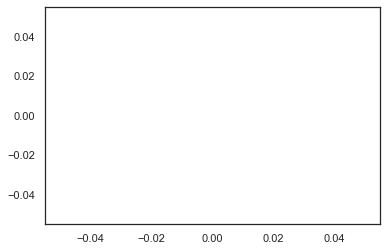

In [211]:
# palette
pal_pub=sns.color_palette("Purples",5)
pal_nordic=sns.color_palette("Blues",5)
pal_fitr=sns.color_palette("coolwarm",10)
pal_lang=sns.color_palette("Oranges",5)
pal_nat=sns.color_palette("Greens",5)
pal_trfi=sns.color_palette("magma",10)
colormap=  { p:m for p,m in zip (list(a_pdf.publisher.unique()), pal_pub)}
colormap2=  { p:m for p,m in zip (list(a_pdf.publisher.unique()), pal_nordic)}
colormap_fitr=  { p:m for p,m in zip (list(a_pdf.publisher.unique()), pal_fitr[:5])}
colormap_trfi=  { p:m for p,m in zip (list(a_pdf.publisher.unique()), pal_trfi[2:8])}
colormap3=  { p:m for p,m in zip (list(a_pdf.publisher.unique()), pal_lang)}
colormap4=  { p:m for p,m in zip (list(a_pdf.publisher.unique()), pal_nat)}


mmap= { p:m for p,m in zip (list(a_pdf.publisher.unique()), ["o","d","s","v","*"])}

fu = lambda m,c: plt.plot([],[],marker=m, color=c, ls="none")[0]
my_handles = [fu(mmap[key], "grey") for key in mmap.keys()]
my_labels = list(mmap.keys())

In [212]:
new_labels=[]
for l,v in mmap.items():
    print(l)
    new_l=all_pubs[all_pubs["publisher"]==l]["pubName"].iloc[0]
    new_labels.append(new_l)
print(new_labels)    
new_labels=['WSOY',
 'Otava',
 'Tammi',
 'Karisto',
 'Gummerus']

http://www.yso.fi/onto/kaunokki#Kustantaja_123272659490249
http://www.yso.fi/onto/kaunokki#Kustantaja_123272660482316
http://www.yso.fi/onto/kaunokki#Kustantaja_123175899745141
http://www.yso.fi/onto/kaunokki#Kustantaja_123272667729627
http://www.yso.fi/onto/kaunokki#Kustantaja_123175899315611
['WSOY', 'Otava', 'Tammi', 'Karisto Oy', 'Gummerus']


In [216]:
# fi - tr ratio

fi_tr=total_per.merge(total_per_fi, on=["period","publisher"], suffixes=["","_fi"])
fi_tr["rel"]=fi_tr["teos_fi"]/(fi_tr["teos_fi"]+fi_tr["teos"])



http://www.yso.fi/onto/kaunokki#Kustantaja_123272659490249 o
http://www.yso.fi/onto/kaunokki#Kustantaja_123272660482316 d
http://www.yso.fi/onto/kaunokki#Kustantaja_123175899745141 s
http://www.yso.fi/onto/kaunokki#Kustantaja_123272667729627 v
http://www.yso.fi/onto/kaunokki#Kustantaja_123175899315611 *


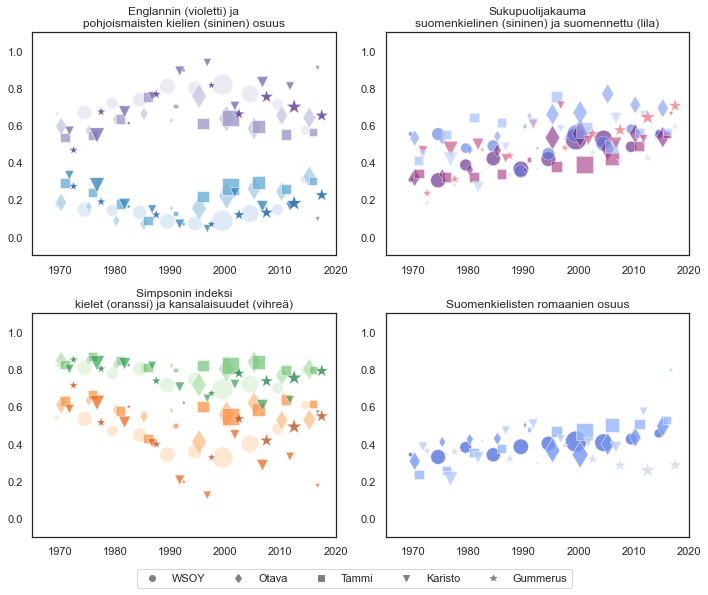

In [223]:
# plot these 4 things
fig , ax = plt.subplots(2, 2, figsize=(10,8))
#mmap={"jannitys":"p","rakkaus":"o","huumori":"s"}
#mmap= { p:m for p,m in zip (list(a_pdf.publisher.unique()), ["o","d","s","v","*"])}

# eng share
n=-1.5
for key,mval in mmap.items():
    print(key,mval)
    temp=eng_df.drop_duplicates(["period","publisher"])
    temp=temp[temp["publisher"]==key]
    max_size=temp["teos"].max()
    ax[0][0]=sns.scatterplot(x=temp['period']+n,y=temp["rel_eng"],marker=mval,ax=ax[0][0],
                          #hue=temp["publisher"], 
                             color=colormap[key],
                             size=temp["teos"], 
                          sizes=(20,max_size),  alpha=0.8 )
    
    temp2=nordic_df.drop_duplicates(["period","publisher"])
    temp2=temp2[temp2["publisher"]==key]
    ax[0][0]=sns.scatterplot(x=temp2['period']+n,y=temp2["rel_nordic"],marker=mval,ax=ax[0][0],
                          color=colormap2[key], size=temp2["teos"], 
                          sizes=(20,max_size), #palette=pal_nordic,hue_norm=(0,1), 
                             alpha=0.8 )
    #temp.plot.line(x="period",y="nordic_share", ax= ax[0][0], color=pal_nordic[2])
    #temp.plot.line(x="period",y="eng_share", ax= ax[0][0], color=pal_eng[2])
    ax[0][0].legend([],[], frameon=False)
    ax[0][0].set_title("Englannin (violetti) ja\npohjoismaisten kielien (sininen) osuus")
    ax[0][0].set(ylabel=None,xlabel=None)
    ax[0][0].set(ylim=(-0.1, 1.1), xlim=(1965,2020))
    n+=0.75

# sukupuolijakauma, lisää kotimainen!
n=-1.5
for key,mval in mmap.items():
    temp=gender_period.drop_duplicates(["period","publisher"])
    temp=temp[temp["publisher"]==key]
    max_size=temp["teos"].max()
    ax[0][0]=sns.scatterplot(x=temp['period']+n,y=temp["rel_gender"],marker=mval,ax=ax[0][1],
                          #hue=temp["rel_gender"], palette=sns.color_palette("PuOr", as_cmap=True),
                            # color=colormap[key],
                             #color=sns.color_palette("PuOr")[5],
                             color=colormap_trfi[key],
                             size=temp["teos"], 
                          sizes=(20,max_size),  alpha=0.6 )
    
    temp2=gender_period_fi.drop_duplicates(["period","publisher"])
    temp2=temp2[temp2["publisher"]==key]
    max_size=temp2["teos"].max()
    ax[0][0]=sns.scatterplot(x=temp2['period']+n,y=temp2["rel_gender"],marker=mval,ax=ax[0][1],
                          #hue=temp2["rel_gender"], palette=sns.color_palette("coolwarm", as_cmap=True),
                            # color=colormap[key],
                             color=colormap_fitr[key],
                             size=temp["teos"], 
                          sizes=(20,max_size),  alpha=0.6 )
    
   
    #temp.plot.line(x="period",y="nordic_share", ax= ax[0][0], color=pal_nordic[2])
    #temp.plot.line(x="period",y="eng_share", ax= ax[0][0], color=pal_eng[2])
    ax[0][0].legend([],[], frameon=False)
    ax[0][0].set_title("Sukupuolijakauma\nsuomenkielinen (sininen) ja suomennettu (lila)")
    ax[0][0].set(ylabel=None,xlabel=None)
    ax[0][0].set(ylim=(-0.1, 1.1), xlim=(1965,2020))
    n+=0.75

    
# simpson
n=-1.5
for key,mval in mmap.items():
    temp=simpson_lang.drop_duplicates(["period","publisher"])
    temp=temp[temp["publisher"]==key]
    max_size=temp["teos"].max()
    ax[0][0]=sns.scatterplot(x=temp['period']+n,y=temp["simpson"],marker=mval,ax=ax[1][0],
                          #hue=temp["publisher"], 
                             color=colormap3[key],
                             size=temp["teos"], 
                          sizes=(20,max_size),  alpha=0.7 )
    
    temp2=simpson_nat.drop_duplicates(["period","publisher"])
    temp2=temp2[temp2["publisher"]==key]
    ax[0][0]=sns.scatterplot(x=temp2['period']+n,y=temp2["simpson"],marker=mval,ax=ax[1][0],
                          color=colormap4[key], size=temp2["teos"], 
                          sizes=(20,max_size), #palette=pal_nordic,hue_norm=(0,1), 
                             alpha=0.7 )
    #temp.plot.line(x="period",y="nordic_share", ax= ax[0][0], color=pal_nordic[2])
    #temp.plot.line(x="period",y="eng_share", ax= ax[0][0], color=pal_eng[2])
    ax[0][0].legend([],[], frameon=False)
    ax[0][0].set_title("Simpsonin indeksi\nkielet (oranssi) ja kansalaisuudet (vihreä)")
    ax[0][0].set(ylabel=None,xlabel=None)
    ax[0][0].set(ylim=(-0.1, 1.1), xlim=(1965,2020))
    n+=0.75
    
   
n=-1.5
for key,mval in mmap.items():
    temp=fi_tr.drop_duplicates(["period","publisher"])
    temp=temp[temp["publisher"]==key]
    max_size=temp["teos"].max()
    ax[0][0]=sns.scatterplot(x=temp['period']+n,y=temp["rel"],marker=mval,ax=ax[1][1],
                          #hue=temp["publisher"], 
                             color=colormap_fitr[key],
                             size=temp["teos"], 
                          sizes=(20,max_size),  alpha=0.8 )
    
    
    ax[0][0].legend([],[], frameon=False)
    ax[0][0].set_title("Suomenkielisten romaanien osuus")
    ax[0][0].set(ylabel=None,xlabel=None)
    ax[0][0].set(ylim=(-0.1, 1.1), xlim=(1965,2020))
    n+=0.75


fig.tight_layout()
lgd=fig.legend(loc='upper center', bbox_to_anchor=(0.5, 
                                              0.01), ncol=5,
           handles=my_handles, labels=new_labels)
fig.tight_layout()
fig.savefig("../../output/5_kustantamoa_new.png",bbox_extra_artists=(lgd,),bbox_inches='tight')

In [18]:
# compare fis

df_fi_old=pd.read_csv("../../data/df_fi_all.csv", sep="\t", index_col=0)
old_novels=[str(n) for n in df_fi_old["novel"]]
mystery_novels=[d for d in df_fi.novel.unique() if d not in old_novels]

In [21]:
print(len(mystery_novels))
print(len(df_fi), len(df_fi_old), len(df_fi))

190
17240 17028 17240


In [25]:
MY_VALUES = ["<"+str(n)+">" for n in mystery_novels]
valuestring=" ".join(MY_VALUES)

In [39]:
# query mystery_novels

# query labels
Q ="""
SELECT  DISTINCT  *  WHERE {

?novel rdf:type ?class .
VALUES ?novel { MY_VALUES }
?novel kaunokki:alkukieli ?lang .
?novel skos:prefLabel ?nimi . FILTER(LANG(?nimi)="fi")
?novel kaunokki:manifests_in ?pub .
?pub kaunokki:ilmestymisvuosi ?vuosi .
?vuosi skos:prefLabel ?year .

#FILTER NOT EXISTS { xsd:int(?year) < 1970 }

} 
    

"""

#sparql = SPARQLWrapper("http://ldf.fi/kirjasampo/sparql")

#nat_labels=pd.DataFrame()
#for nat in df_fo2["nat"].unique():
sparql = SPARQLWrapper("http://ldf.fi/booksampo-2022/sparql")
q=Q.replace("MY_VALUES", valuestring)
sparql.setQuery(PREFIXES + q)
sparql.setReturnFormat(JSON)
sparql.addCustomHttpHeader(*list(AUTHORIZATION_HEADER.items())[0])
results = sparql.query().convert()
temp = JSON2Pandas2(results)

    



In [43]:
temp.lang.unique()
temp[temp["lang"]=='http://lexvo.org/id/iso639-3/eng']
temp["year"]= pd.to_numeric(temp["year"])
temp[temp["year"]<1971]
temp["class"].unique()

array(['http://www.yso.fi/onto/kaunokki#romaani',
       'http://www.yso.fi/onto/kaunokki#kokoomateos',
       'http://www.yso.fi/onto/kaunokki#novellikokoelma'], dtype=object)

In [65]:
temp.head(20)

,novel,class,lang,nimi,pub,vuosi,year
0,http://www.yso.fi/onto/kaunokki#ateos_12403,http://www.yso.fi/onto/kaunokki#romaani,http://lexvo.org/id/iso639-3/fin,Uspenskin varjossa,http://www.yso.fi/onto/kaunokki#Instance_ID123...,http://www.kulttuurisampo.fi/data/time_1972_1972,1972
1,http://www.yso.fi/onto/kaunokki#ateos_12403,http://www.yso.fi/onto/kaunokki#romaani,http://lexvo.org/id/iso639-3/fin,Uspenskin varjossa,http://seco.tkk.fi/saha3/udb5d0d30-a250-43f5-a...,http://www.kulttuurisampo.fi/data/time_1973_1973,1973
2,http://seco.tkk.fi/saha3/uf529236b-54c9-4869-a...,http://www.yso.fi/onto/kaunokki#romaani,http://lexvo.org/id/iso639-3/fin,"Minä, Cassie",http://seco.tkk.fi/saha3/uc245dc46-2eef-4d8a-9...,http://www.kulttuurisampo.fi/data/time_1972_1972,1972
3,http://seco.tkk.fi/saha3/udf223005-fb73-4dbc-9...,http://www.yso.fi/onto/kaunokki#romaani,http://lexvo.org/id/iso639-3/fin,Laiva,http://seco.tkk.fi/saha3/udae16236-1dff-4ec1-a...,http://www.kulttuurisampo.fi/data/time_1972_1972,1972
4,http://www.yso.fi/onto/kaunokki#ateos_29319,http://www.yso.fi/onto/kaunokki#romaani,http://lexvo.org/id/iso639-3/fin,Naulan kantaan,http://www.yso.fi/onto/kaunokki#Instance_ID123...,http://www.kulttuurisampo.fi/data/time_1973_1973,1973
5,http://www.yso.fi/onto/kaunokki#ateos_32478,http://www.yso.fi/onto/kaunokki#romaani,http://lexvo.org/id/iso639-3/fin,Vuoren jyly,http://www.yso.fi/onto/kaunokki#Instance_ID123...,http://www.kulttuurisampo.fi/data/time_1973_1973,1973
6,http://www.yso.fi/onto/kaunokki#ateos_32478,http://www.yso.fi/onto/kaunokki#romaani,http://lexvo.org/id/iso639-3/fin,Vuoren jyly,http://seco.tkk.fi/saha3/u844bff42-25a9-4b83-b...,http://www.kulttuurisampo.fi/data/time_1949_1949,1949
7,http://www.yso.fi/onto/kaunokki#ateos_57437,http://www.yso.fi/onto/kaunokki#romaani,http://lexvo.org/id/iso639-3/fin,Maiseman silmä,http://www.yso.fi/onto/kaunokki#Instance_ID123...,http://www.kulttuurisampo.fi/data/time_1973_1973,1973
8,http://www.yso.fi/onto/kaunokki#ateos_23803,http://www.yso.fi/onto/kaunokki#romaani,http://lexvo.org/id/iso639-3/fin,Takalan talossa tapahtuu,http://www.yso.fi/onto/kaunokki#Instance_ID123...,http://www.kulttuurisampo.fi/data/time_1974_1974,1974
9,http://www.yso.fi/onto/kaunokki#ateos_58159,http://www.yso.fi/onto/kaunokki#romaani,http://lexvo.org/id/iso639-3/fin,Valikoima Nätti-Jussin tarinoita,http://www.yso.fi/onto/kaunokki#Instance_ID123...,http://www.kulttuurisampo.fi/data/time_1974_1974,1974


In [66]:
df_fi.sample()

,year,author,nat,gender,novel,publisher,pubName,genre,year_genre,decade
11133,2016,http://www.btj.fi/actor_Heikkinen%2C+Antti,http://www.yso.fi/onto/koko/p35259,http://www.yso.fi/onto/kaunokki#male,http://data.kirjasampo.fi/abstractWork_4339800,http://www.seco.tkk.fi/applications/saha#Insta...,Siltala,huumori,2016.0,2010.0
